## Quantum 3D Segmentation ##

**Goal:** Convert the IQFT Segmentation algorithm to use a quantum circuit instead of matrices

In [5]:


import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path as op
import os
from PIL import Image
import sys
from tqdm import tqdm
sys.path.append('./')

In [4]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [6]:
def im2arr(file_path: str, RGB: bool = False, resize: tuple = None):
# load grayscale image
    if RGB:    
        img = Image.open(file_path).convert("RGB") #convert to grayscale; use "RGB" for RGB
    else:
        img = Image.open(file_path).convert("L") #convert to grayscale; use "RGB" for RGB
    if resize is not None:
        img = img.resize(resize)
    return np.array(img)

def img2ang(image, imax=255, imin=0):
        if imax is None: imax = np.max(image)
        tmp = ((image - imin) / (imax - imin)) * 255
        out = tmp / 255.
        return out

In [7]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi

def iqft_seg(image_array: np.ndarray, lm: list, shots: int) -> np.ndarray:  #lm is a list of different theta values
    """
    Perform image segmentation based on the inverse quantum Fourier transform on a given (normalized) image array.

    Args:
        image_array: A 2D numpy array representing the image to be segmented.
        lm: A list of theta values for the inverse quantum Fourier transform.
        shots: The number of shots to be used when executing the quantum circuit.

    Returns:
        A 2D numpy array containing the class labels of each pixel in the image.
    """

    if len(image_array.shape) == 3: #if the image is RGB, use 3 qubits
        num_qubits = 3
    elif len(image_array.shape) == 2:   
        num_qubits = 1
    else:
        raise ValueError('Incorrect Dimension')

    nrow, ncol = image_array.shape[:2]
    label_array = np.zeros((nrow, ncol))

    for i in tqdm(range(nrow)):
        for j in range(ncol):
            qc = QuantumCircuit(num_qubits)
            for k in range(num_qubits):
                angles = np.multiply(image_array[i, j], np.array(lm))[::-1] # thanks to Qiskit's annyoing little endian convention
                qc.h(k)
                qc.p(angles[k], k)
            qft_circ = QFT(num_qubits).inverse()
            #qft_circ.draw(output = 'mpl')
            qc.append(qft_circ, range(num_qubits))
            qc.measure_all()

            sampler = Sampler(options={"shots": shots})
            probs = sampler.run(qc).result().quasi_dists[0]
            if i % 20 == 0 and j % 20 == 0:
                print(probs)
            # Choose the class label based on the highest probability
            label_array[i, j] = max(probs, key=probs.get)
    
    return label_array

In [8]:
image = im2arr('demo.png')
ang = img2ang(image)
print(ang.shape)
lm = [np.pi]
shots = 1000
label_array = iqft_seg(ang, lm, shots)

(994, 1102)


  0%|                                                   | 0/994 [00:00<?, ?it/s]

{0: 0.106, 1: 0.894}
{0: 0.337, 1: 0.663}
{0: 0.522, 1: 0.478}
{0: 0.412, 1: 0.588}
{0: 0.17, 1: 0.83}
{0: 0.034, 1: 0.966}
{0: 0.175, 1: 0.825}
{0: 0.229, 1: 0.771}
{0: 0.754, 1: 0.246}
{0: 0.349, 1: 0.651}
{0: 0.228, 1: 0.772}
{0: 0.275, 1: 0.725}
{0: 0.267, 1: 0.733}
{0: 0.28, 1: 0.72}
{0: 0.329, 1: 0.671}
{0: 0.333, 1: 0.667}
{0: 0.284, 1: 0.716}
{0: 0.902, 1: 0.098}
{0: 0.138, 1: 0.862}
{0: 0.081, 1: 0.919}
{0: 0.482, 1: 0.518}
{0: 0.209, 1: 0.791}
{0: 0.224, 1: 0.776}
{0: 0.22, 1: 0.78}
{0: 0.06, 1: 0.94}
{0: 0.261, 1: 0.739}
{0: 0.464, 1: 0.536}
{0: 0.249, 1: 0.751}
{0: 0.179, 1: 0.821}
{0: 0.919, 1: 0.081}
{0: 0.322, 1: 0.678}
{0: 0.864, 1: 0.136}
{0: 0.82, 1: 0.18}
{0: 0.107, 1: 0.893}
{0: 0.915, 1: 0.085}
{0: 0.205, 1: 0.795}
{0: 0.389, 1: 0.611}
{0: 0.256, 1: 0.744}
{0: 0.175, 1: 0.825}
{0: 0.204, 1: 0.796}
{0: 0.193, 1: 0.807}
{0: 0.503, 1: 0.497}
{0: 0.146, 1: 0.854}
{0: 0.209, 1: 0.791}
{0: 0.192, 1: 0.808}
{0: 0.201, 1: 0.799}
{0: 0.175, 1: 0.825}
{0: 0.124, 1: 0.876}
{0

  0%|                                           | 1/994 [00:02<42:49,  2.59s/it]

{0: 0.913, 1: 0.087}
{0: 0.84, 1: 0.16}


  2%|▊                                         | 20/994 [00:48<38:37,  2.38s/it]

{0: 0.361, 1: 0.639}
{0: 0.471, 1: 0.529}
{0: 0.365, 1: 0.635}
{0: 0.295, 1: 0.705}
{0: 0.057, 1: 0.943}
{0: 0.012, 1: 0.988}
{0: 0.151, 1: 0.849}
{0: 0.375, 1: 0.625}
{0: 0.478, 1: 0.522}
{0: 0.266, 1: 0.734}
{0: 0.269, 1: 0.731}
{0: 0.403, 1: 0.597}
{0: 0.291, 1: 0.709}
{0: 0.286, 1: 0.714}
{0: 0.316, 1: 0.684}
{0: 0.245, 1: 0.755}
{0: 0.583, 1: 0.417}
{0: 0.568, 1: 0.432}
{0: 0.674, 1: 0.326}
{0: 0.688, 1: 0.312}
{0: 0.388, 1: 0.612}
{0: 0.317, 1: 0.683}
{0: 0.346, 1: 0.654}
{0: 0.447, 1: 0.553}
{0: 0.142, 1: 0.858}
{0: 0.436, 1: 0.564}
{0: 0.367, 1: 0.633}
{0: 0.292, 1: 0.708}
{0: 0.256, 1: 0.744}
{0: 0.205, 1: 0.795}
{0: 0.35, 1: 0.65}
{0: 0.187, 1: 0.813}
{0: 0.3, 1: 0.7}
{0: 0.563, 1: 0.437}
{0: 0.301, 1: 0.699}
{0: 0.335, 1: 0.665}
{0: 0.271, 1: 0.729}
{0: 0.214, 1: 0.786}
{0: 0.14, 1: 0.86}
{0: 0.261, 1: 0.739}
{0: 0.255, 1: 0.745}
{0: 0.161, 1: 0.839}
{0: 0.216, 1: 0.784}
{0: 0.221, 1: 0.779}
{0: 0.207, 1: 0.793}
{0: 0.214, 1: 0.786}
{0: 0.234, 1: 0.766}
{0: 0.316, 1: 0.684}


  2%|▉                                         | 21/994 [00:50<38:59,  2.40s/it]

{0: 0.853, 1: 0.147}
{0: 0.903, 1: 0.097}
{0: 0.887, 1: 0.113}
{0: 0.854, 1: 0.146}
{0: 0.871, 1: 0.129}


  4%|█▋                                        | 40/994 [01:38<38:47,  2.44s/it]

{0: 0.398, 1: 0.602}
{0: 0.303, 1: 0.697}
{0: 0.623, 1: 0.377}
{0: 0.583, 1: 0.417}
{0: 0.114, 1: 0.886}
{0: 0.022, 1: 0.978}
{0: 0.102, 1: 0.898}
{0: 0.414, 1: 0.586}
{0: 0.644, 1: 0.356}
{0: 0.675, 1: 0.325}
{0: 0.451, 1: 0.549}
{0: 0.233, 1: 0.767}
{0: 0.441, 1: 0.559}
{0: 0.405, 1: 0.595}
{0: 0.192, 1: 0.808}
{0: 0.746, 1: 0.254}
{0: 0.483, 1: 0.517}
{0: 0.256, 1: 0.744}
{0: 0.304, 1: 0.696}
{0: 0.237, 1: 0.763}
{0: 0.328, 1: 0.672}
{0: 0.649, 1: 0.351}
{0: 0.373, 1: 0.627}
{0: 0.304, 1: 0.696}
{0: 0.41, 1: 0.59}
{0: 0.428, 1: 0.572}
{0: 0.255, 1: 0.745}
{0: 0.278, 1: 0.722}
{0: 0.242, 1: 0.758}
{0: 0.203, 1: 0.797}
{0: 0.187, 1: 0.813}
{0: 0.218, 1: 0.782}
{0: 0.224, 1: 0.776}
{0: 0.252, 1: 0.748}
{0: 0.352, 1: 0.648}
{0: 0.153, 1: 0.847}
{0: 0.387, 1: 0.613}
{0: 0.191, 1: 0.809}
{0: 0.091, 1: 0.909}
{0: 0.254, 1: 0.746}
{0: 0.257, 1: 0.743}
{0: 0.268, 1: 0.732}
{0: 0.216, 1: 0.784}
{0: 0.158, 1: 0.842}
{0: 0.132, 1: 0.868}
{0: 0.189, 1: 0.811}
{0: 0.212, 1: 0.788}
{0: 0.617, 1: 0

  4%|█▋                                        | 41/994 [01:40<38:53,  2.45s/it]

{0: 0.805, 1: 0.195}
{0: 0.95, 1: 0.05}
{0: 0.886, 1: 0.114}
{0: 0.808, 1: 0.192}
{0: 0.858, 1: 0.142}


  6%|██▌                                       | 60/994 [02:31<44:46,  2.88s/it]

{0: 0.522, 1: 0.478}
{0: 0.803, 1: 0.197}
{0: 0.872, 1: 0.128}
{0: 0.729, 1: 0.271}
{0: 0.14, 1: 0.86}
{0: 0.065, 1: 0.935}
{0: 0.078, 1: 0.922}
{0: 0.315, 1: 0.685}
{0: 0.275, 1: 0.725}
{0: 0.575, 1: 0.425}
{0: 0.596, 1: 0.404}
{0: 0.182, 1: 0.818}
{0: 0.305, 1: 0.695}
{0: 0.855, 1: 0.145}
{0: 0.89, 1: 0.11}
{0: 0.883, 1: 0.117}
{0: 0.488, 1: 0.512}
{0: 0.462, 1: 0.538}
{0: 0.239, 1: 0.761}
{0: 0.184, 1: 0.816}
{0: 0.201, 1: 0.799}
{0: 0.136, 1: 0.864}
{0: 0.255, 1: 0.745}
{0: 0.824, 1: 0.176}
{0: 0.358, 1: 0.642}
{0: 0.292, 1: 0.708}
{0: 0.121, 1: 0.879}
{0: 0.266, 1: 0.734}
{0: 0.221, 1: 0.779}
{0: 0.039, 1: 0.961}
{0: 0.51, 1: 0.49}
{0: 0.294, 1: 0.706}
{0: 0.497, 1: 0.503}
{0: 0.174, 1: 0.826}
{0: 0.341, 1: 0.659}
{0: 0.492, 1: 0.508}
{0: 0.325, 1: 0.675}
{0: 0.194, 1: 0.806}
{0: 0.153, 1: 0.847}
{0: 0.286, 1: 0.714}
{0: 0.236, 1: 0.764}
{0: 0.249, 1: 0.751}
{0: 0.207, 1: 0.793}
{0: 0.163, 1: 0.837}
{0: 0.212, 1: 0.788}
{0: 0.141, 1: 0.859}
{0: 0.225, 1: 0.775}
{0: 0.865, 1: 0.135

  6%|██▌                                       | 61/994 [02:34<45:20,  2.92s/it]

{0: 0.812, 1: 0.188}
{0: 0.813, 1: 0.187}


  8%|███▍                                      | 80/994 [03:25<39:13,  2.57s/it]

{0: 0.933, 1: 0.067}
{0: 0.282, 1: 0.718}
{0: 0.944, 1: 0.056}
{0: 0.548, 1: 0.452}
{0: 0.121, 1: 0.879}
{0: 0.061, 1: 0.939}
{0: 0.185, 1: 0.815}
{0: 0.235, 1: 0.765}
{0: 0.254, 1: 0.746}
{0: 0.167, 1: 0.833}
{0: 0.911, 1: 0.089}
{0: 0.903, 1: 0.097}
{0: 0.897, 1: 0.103}
{0: 0.941, 1: 0.059}
{0: 0.935, 1: 0.065}
{0: 0.44, 1: 0.56}
{0: 0.249, 1: 0.751}
{0: 0.48, 1: 0.52}
{0: 0.153, 1: 0.847}
{0: 0.483, 1: 0.517}
{0: 0.23, 1: 0.77}
{0: 0.865, 1: 0.135}
{0: 0.179, 1: 0.821}
{0: 0.625, 1: 0.375}
{0: 0.896, 1: 0.104}
{0: 0.856, 1: 0.144}
{0: 0.161, 1: 0.839}
{0: 0.289, 1: 0.711}
{0: 0.324, 1: 0.676}
{0: 0.534, 1: 0.466}
{0: 0.304, 1: 0.696}
{0: 0.306, 1: 0.694}
{0: 0.193, 1: 0.807}
{0: 0.391, 1: 0.609}
{0: 0.408, 1: 0.592}
{0: 0.436, 1: 0.564}
{0: 0.722, 1: 0.278}
{0: 0.299, 1: 0.701}
{0: 0.146, 1: 0.854}
{0: 0.313, 1: 0.687}
{0: 0.205, 1: 0.795}
{0: 0.243, 1: 0.757}
{0: 0.198, 1: 0.802}
{0: 0.241, 1: 0.759}
{0: 0.184, 1: 0.816}
{0: 0.205, 1: 0.795}
{0: 0.848, 1: 0.152}
{0: 0.829, 1: 0.171

  8%|███▍                                      | 81/994 [03:28<41:46,  2.74s/it]

{0: 0.828, 1: 0.172}


 10%|████                                     | 100/994 [04:18<39:19,  2.64s/it]

{0: 0.807, 1: 0.193}
{0: 0.934, 1: 0.066}
{0: 0.396, 1: 0.604}
{0: 0.706, 1: 0.294}
{0: 0.139, 1: 0.861}
{0: 0.054, 1: 0.946}
{0: 0.047, 1: 0.953}
{0: 0.147, 1: 0.853}
{0: 0.216, 1: 0.784}
{0: 0.86, 1: 0.14}
{0: 0.87, 1: 0.13}
{0: 0.921, 1: 0.079}
{0: 0.891, 1: 0.109}
{0: 0.921, 1: 0.079}
{0: 0.919, 1: 0.081}
{0: 0.167, 1: 0.833}
{0: 0.393, 1: 0.607}
{0: 0.566, 1: 0.434}
{0: 0.365, 1: 0.635}
{0: 0.607, 1: 0.393}
{0: 0.46, 1: 0.54}
{0: 0.318, 1: 0.682}
{0: 0.323, 1: 0.677}
{0: 0.586, 1: 0.414}
{0: 0.325, 1: 0.675}
{0: 0.776, 1: 0.224}
{0: 0.288, 1: 0.712}
{0: 0.291, 1: 0.709}
{0: 0.277, 1: 0.723}
{0: 0.603, 1: 0.397}
{0: 0.16, 1: 0.84}
{0: 0.267, 1: 0.733}
{0: 0.285, 1: 0.715}
{0: 0.46, 1: 0.54}
{0: 0.924, 1: 0.076}
{0: 0.293, 1: 0.707}
{0: 0.414, 1: 0.586}
{0: 0.388, 1: 0.612}
{0: 0.222, 1: 0.778}
{0: 0.36, 1: 0.64}
{0: 0.227, 1: 0.773}
{0: 0.219, 1: 0.781}
{0: 0.24, 1: 0.76}
{0: 0.158, 1: 0.842}
{0: 0.203, 1: 0.797}
{0: 0.192, 1: 0.808}
{0: 0.843, 1: 0.157}
{0: 0.83, 1: 0.17}
{0: 0.89

 10%|████▏                                    | 101/994 [04:21<39:54,  2.68s/it]

{0: 0.84, 1: 0.16}


 12%|████▉                                    | 120/994 [05:11<37:50,  2.60s/it]

{0: 0.277, 1: 0.723}
{0: 0.87, 1: 0.13}
{0: 0.975, 1: 0.025}
{0: 0.386, 1: 0.614}
{0: 0.276, 1: 0.724}
{0: 0.049, 1: 0.951}
{0: 0.057, 1: 0.943}
{0: 0.174, 1: 0.826}
{0: 0.178, 1: 0.822}
{0: 0.641, 1: 0.359}
{0: 0.877, 1: 0.123}
{0: 0.933, 1: 0.067}
{0: 0.937, 1: 0.063}
{0: 0.952, 1: 0.048}
{0: 0.888, 1: 0.112}
{0: 0.888, 1: 0.112}
{0: 0.809, 1: 0.191}
{0: 0.886, 1: 0.114}
{0: 0.16, 1: 0.84}
{0: 0.81, 1: 0.19}
{0: 0.856, 1: 0.144}
{0: 0.432, 1: 0.568}
{0: 0.927, 1: 0.073}
{0: 0.903, 1: 0.097}
{0: 0.202, 1: 0.798}
{0: 0.175, 1: 0.825}
{0: 0.315, 1: 0.685}
{0: 0.254, 1: 0.746}
{0: 0.241, 1: 0.759}
{0: 0.098, 1: 0.902}
{0: 0.629, 1: 0.371}
{0: 0.577, 1: 0.423}
{0: 0.678, 1: 0.322}
{0: 0.948, 1: 0.052}
{0: 0.905, 1: 0.095}
{0: 0.153, 1: 0.847}
{0: 0.45, 1: 0.55}
{0: 0.301, 1: 0.699}
{0: 0.259, 1: 0.741}
{0: 0.229, 1: 0.771}
{0: 0.26, 1: 0.74}
{0: 0.232, 1: 0.768}
{0: 0.225, 1: 0.775}
{0: 0.222, 1: 0.778}
{0: 0.223, 1: 0.777}
{0: 0.282, 1: 0.718}
{0: 0.423, 1: 0.577}
{0: 0.848, 1: 0.152}
{0

 12%|████▉                                    | 121/994 [05:14<36:58,  2.54s/it]

{0: 0.955, 1: 0.045}
{0: 0.832, 1: 0.168}
{0: 0.759, 1: 0.241}
{0: 0.832, 1: 0.168}
{0: 0.895, 1: 0.105}


 14%|█████▊                                   | 140/994 [06:04<38:30,  2.71s/it]

{0: 0.661, 1: 0.339}
{0: 0.896, 1: 0.104}
{0: 0.921, 1: 0.079}
{0: 0.343, 1: 0.657}
{0: 0.453, 1: 0.547}
{0: 0.727, 1: 0.273}
{0: 0.087, 1: 0.913}
{0: 0.883, 1: 0.117}
{0: 0.869, 1: 0.131}
{0: 0.898, 1: 0.102}
{0: 0.913, 1: 0.087}
{0: 0.918, 1: 0.082}
{0: 0.914, 1: 0.086}
{0: 0.996, 1: 0.004}
{0: 0.907, 1: 0.093}
{0: 0.896, 1: 0.104}
{0: 0.938, 1: 0.062}
{0: 0.911, 1: 0.089}
{0: 0.878, 1: 0.122}
{0: 0.641, 1: 0.359}
{0: 0.11, 1: 0.89}
{0: 0.2, 1: 0.8}
{0: 0.71, 1: 0.29}
{0: 0.621, 1: 0.379}
{0: 0.078, 1: 0.922}
{0: 0.041, 1: 0.959}
{0: 0.13, 1: 0.87}
{0: 0.205, 1: 0.795}
{0: 0.96, 1: 0.04}
{0: 0.597, 1: 0.403}
{0: 0.578, 1: 0.422}
{0: 0.566, 1: 0.434}
{0: 0.603, 1: 0.397}
{0: 0.976, 1: 0.024}
{0: 0.213, 1: 0.787}
{0: 0.072, 1: 0.928}
{0: 0.265, 1: 0.735}
{0: 0.348, 1: 0.652}
{0: 0.237, 1: 0.763}
{0: 0.256, 1: 0.744}
{0: 0.275, 1: 0.725}
{0: 0.205, 1: 0.795}
{0: 0.207, 1: 0.793}
{0: 0.241, 1: 0.759}
{0: 0.257, 1: 0.743}
{0: 0.199, 1: 0.801}
{0: 0.362, 1: 0.638}
{0: 0.857, 1: 0.143}
{0: 

 14%|█████▊                                   | 141/994 [06:06<38:00,  2.67s/it]

{0: 0.784, 1: 0.216}
{0: 0.809, 1: 0.191}


 16%|██████▌                                  | 160/994 [06:59<39:25,  2.84s/it]

{0: 0.454, 1: 0.546}
{0: 0.965, 1: 0.035}
{0: 0.462, 1: 0.538}
{0: 0.654, 1: 0.346}
{0: 0.229, 1: 0.771}
{0: 0.241, 1: 0.759}
{0: 0.76, 1: 0.24}
{0: 0.847, 1: 0.153}
{0: 0.9, 1: 0.1}
{0: 0.866, 1: 0.134}
{0: 0.858, 1: 0.142}
{0: 0.875, 1: 0.125}
{0: 0.893, 1: 0.107}
{0: 0.976, 1: 0.024}
{0: 0.347, 1: 0.653}
{0: 0.901, 1: 0.099}
{0: 0.905, 1: 0.095}
{0: 0.91, 1: 0.09}
{0: 0.934, 1: 0.066}
{0: 0.102, 1: 0.898}
{0: 0.254, 1: 0.746}
{0: 0.175, 1: 0.825}
{0: 0.111, 1: 0.889}
{0: 0.85, 1: 0.15}
{0: 0.097, 1: 0.903}
{0: 0.127, 1: 0.873}
{0: 0.12, 1: 0.88}
{0: 0.581, 1: 0.419}
{0: 0.35, 1: 0.65}
{0: 0.601, 1: 0.399}
{0: 0.578, 1: 0.422}
{0: 0.254, 1: 0.746}
{0: 0.552, 1: 0.448}
{0: 0.854, 1: 0.146}
{0: 0.903, 1: 0.097}
{0: 0.174, 1: 0.826}
{0: 0.232, 1: 0.768}
{0: 0.282, 1: 0.718}
{0: 0.31, 1: 0.69}
{0: 0.259, 1: 0.741}
{0: 0.331, 1: 0.669}
{0: 0.241, 1: 0.759}
{0: 0.238, 1: 0.762}
{0: 0.828, 1: 0.172}
{0: 0.082, 1: 0.918}
{0: 0.31, 1: 0.69}
{0: 0.13, 1: 0.87}
{0: 0.845, 1: 0.155}
{0: 0.816, 1

 16%|██████▋                                  | 161/994 [07:02<38:31,  2.77s/it]

{0: 0.897, 1: 0.103}


 18%|███████▍                                 | 180/994 [07:50<34:53,  2.57s/it]

{0: 0.168, 1: 0.832}
{0: 0.811, 1: 0.189}
{0: 0.661, 1: 0.339}
{0: 0.199, 1: 0.801}
{0: 0.002, 1: 0.998}
{0: 0.212, 1: 0.788}
{0: 0.863, 1: 0.137}
{0: 0.825, 1: 0.175}
{0: 0.102, 1: 0.898}
{0: 0.49, 1: 0.51}
{0: 0.471, 1: 0.529}
{0: 0.696, 1: 0.304}
{0: 0.4, 1: 0.6}
{0: 0.277, 1: 0.723}
{0: 0.153, 1: 0.847}
{0: 0.614, 1: 0.386}
{0: 0.916, 1: 0.084}
{0: 0.911, 1: 0.089}
{0: 0.151, 1: 0.849}
{0: 0.189, 1: 0.811}
{0: 0.173, 1: 0.827}
{0: 0.243, 1: 0.757}
{0: 0.214, 1: 0.786}
{0: 0.098, 1: 0.902}
{0: 0.155, 1: 0.845}
{0: 0.227, 1: 0.773}
{0: 0.407, 1: 0.593}
{0: 0.253, 1: 0.747}
{0: 0.235, 1: 0.765}
{0: 0.86, 1: 0.14}
{0: 0.613, 1: 0.387}
{0: 0.228, 1: 0.772}
{0: 0.291, 1: 0.709}
{0: 0.416, 1: 0.584}
{0: 0.907, 1: 0.093}
{0: 0.432, 1: 0.568}
{0: 0.309, 1: 0.691}
{0: 0.227, 1: 0.773}
{0: 0.216, 1: 0.784}
{0: 0.223, 1: 0.777}
{0: 0.261, 1: 0.739}
{0: 0.243, 1: 0.757}
{0: 0.859, 1: 0.141}
{0: 0.846, 1: 0.154}
{0: 0.029, 1: 0.971}
{0: 0.202, 1: 0.798}
{0: 0.133, 1: 0.867}
{0: 0.772, 1: 0.228}


 18%|███████▍                                 | 181/994 [07:53<34:49,  2.57s/it]

{0: 0.852, 1: 0.148}


 20%|████████▏                                | 200/994 [08:44<36:52,  2.79s/it]

{0: 0.33, 1: 0.67}
{0: 0.326, 1: 0.674}
{0: 0.223, 1: 0.777}
{0: 0.734, 1: 0.266}
{0: 0.844, 1: 0.156}
{0: 0.822, 1: 0.178}
{0: 0.81, 1: 0.19}
{0: 0.886, 1: 0.114}
{0: 0.867, 1: 0.133}
{0: 0.862, 1: 0.138}
{0: 0.22, 1: 0.78}
{0: 0.865, 1: 0.135}
{0: 0.829, 1: 0.171}
{0: 0.466, 1: 0.534}
{0: 0.848, 1: 0.152}
{0: 0.31, 1: 0.69}
{0: 0.947, 1: 0.053}
{0: 0.182, 1: 0.818}
{0: 0.264, 1: 0.736}
{0: 0.228, 1: 0.772}
{0: 0.145, 1: 0.855}
{0: 0.142, 1: 0.858}
{0: 0.072, 1: 0.928}
{0: 0.136, 1: 0.864}
{0: 0.135, 1: 0.865}
{0: 0.535, 1: 0.465}
{0: 0.322, 1: 0.678}
{0: 0.187, 1: 0.813}
{0: 0.706, 1: 0.294}
{0: 0.912, 1: 0.088}
{0: 0.575, 1: 0.425}
{0: 0.228, 1: 0.772}
{0: 0.317, 1: 0.683}
{0: 0.43, 1: 0.57}
{0: 0.87, 1: 0.13}
{0: 0.145, 1: 0.855}
{0: 0.278, 1: 0.722}
{0: 0.271, 1: 0.729}
{0: 0.268, 1: 0.732}
{0: 0.185, 1: 0.815}
{0: 0.725, 1: 0.275}
{0: 0.852, 1: 0.148}
{0: 0.826, 1: 0.174}
{0: 0.774, 1: 0.226}
{0: 0.07, 1: 0.93}
{0: 0.221, 1: 0.779}
{0: 0.572, 1: 0.428}
{0: 0.773, 1: 0.227}
{0: 0.

 20%|████████▎                                | 201/994 [08:47<36:24,  2.76s/it]

{0: 0.835, 1: 0.165}


 22%|█████████                                | 220/994 [09:39<34:21,  2.66s/it]

{0: 0.909, 1: 0.091}
{0: 0.902, 1: 0.098}
{0: 0.84, 1: 0.16}
{0: 0.839, 1: 0.161}
{0: 0.812, 1: 0.188}
{0: 0.858, 1: 0.142}
{0: 0.762, 1: 0.238}
{0: 0.863, 1: 0.137}
{0: 0.866, 1: 0.134}
{0: 0.478, 1: 0.522}
{0: 0.326, 1: 0.674}
{0: 0.186, 1: 0.814}
{0: 0.871, 1: 0.129}
{0: 0.12, 1: 0.88}
{0: 0.239, 1: 0.761}
{0: 0.271, 1: 0.729}
{0: 0.069, 1: 0.931}
{0: 0.446, 1: 0.554}
{0: 0.105, 1: 0.895}
{0: 0.011, 1: 0.989}
{0: 0.101, 1: 0.899}
{0: 0.098, 1: 0.902}
{0: 0.101, 1: 0.899}
{0: 0.163, 1: 0.837}
{0: 0.234, 1: 0.766}
{0: 0.053, 1: 0.947}
{0: 0.397, 1: 0.603}
{0: 0.833, 1: 0.167}
{0: 0.74, 1: 0.26}
{0: 0.705, 1: 0.295}
{0: 0.597, 1: 0.403}
{0: 0.266, 1: 0.734}
{0: 0.238, 1: 0.762}
{0: 0.301, 1: 0.699}
{0: 0.967, 1: 0.033}
{0: 0.158, 1: 0.842}
{0: 0.452, 1: 0.548}
{0: 0.315, 1: 0.685}
{0: 0.22, 1: 0.78}
{0: 0.194, 1: 0.806}
{0: 0.305, 1: 0.695}
{0: 0.835, 1: 0.165}
{0: 0.191, 1: 0.809}
{0: 0.075, 1: 0.925}
{0: 0.207, 1: 0.793}
{0: 0.208, 1: 0.792}
{0: 0.194, 1: 0.806}
{0: 0.829, 1: 0.171}


 22%|█████████                                | 221/994 [09:41<34:17,  2.66s/it]

{0: 0.812, 1: 0.188}


 24%|█████████▉                               | 240/994 [10:46<56:10,  4.47s/it]

{0: 0.9, 1: 0.1}
{0: 0.954, 1: 0.046}
{0: 0.834, 1: 0.166}
{0: 0.754, 1: 0.246}
{0: 0.706, 1: 0.294}
{0: 0.23, 1: 0.77}
{0: 0.292, 1: 0.708}
{0: 0.282, 1: 0.718}
{0: 0.285, 1: 0.715}
{0: 0.387, 1: 0.613}
{0: 0.044, 1: 0.956}
{0: 0.116, 1: 0.884}
{0: 0.81, 1: 0.19}
{0: 0.134, 1: 0.866}
{0: 0.869, 1: 0.131}
{0: 0.125, 1: 0.875}
{0: 0.277, 1: 0.723}
{0: 0.146, 1: 0.854}
{0: 0.268, 1: 0.732}
{0: 0.226, 1: 0.774}
{0: 0.158, 1: 0.842}
{0: 0.129, 1: 0.871}
{0: 0.209, 1: 0.791}
{0: 0.302, 1: 0.698}
{0: 0.238, 1: 0.762}
{0: 0.295, 1: 0.705}
{0: 0.812, 1: 0.188}
{0: 0.777, 1: 0.223}
{0: 0.789, 1: 0.211}
{0: 0.538, 1: 0.462}
{0: 0.66, 1: 0.34}
{0: 0.394, 1: 0.606}
{0: 0.221, 1: 0.779}
{0: 0.658, 1: 0.342}
{0: 0.858, 1: 0.142}
{0: 0.883, 1: 0.117}
{0: 0.457, 1: 0.543}
{0: 0.213, 1: 0.787}
{0: 0.292, 1: 0.708}
{0: 0.273, 1: 0.727}
{0: 0.374, 1: 0.626}
{0: 0.183, 1: 0.817}
{0: 0.208, 1: 0.792}
{0: 0.251, 1: 0.749}
{0: 0.213, 1: 0.787}
{0: 0.18, 1: 0.82}
{0: 0.183, 1: 0.817}
{0: 0.833, 1: 0.167}
{0: 

 24%|█████████▉                               | 241/994 [10:51<59:23,  4.73s/it]

{0: 0.788, 1: 0.212}
{0: 0.864, 1: 0.136}
{0: 0.838, 1: 0.162}


 26%|██████████▋                              | 260/994 [12:15<45:28,  3.72s/it]

{0: 0.739, 1: 0.261}
{0: 0.796, 1: 0.204}
{0: 0.801, 1: 0.199}
{0: 0.838, 1: 0.162}
{0: 0.116, 1: 0.884}
{0: 0.207, 1: 0.793}
{0: 0.269, 1: 0.731}
{0: 0.171, 1: 0.829}
{0: 0.396, 1: 0.604}
{0: 0.041, 1: 0.959}
{0: 0.063, 1: 0.937}
{0: 0.556, 1: 0.444}
{0: 0.508, 1: 0.492}
{0: 0.198, 1: 0.802}
{0: 0.155, 1: 0.845}
{0: 0.345, 1: 0.655}
{0: 0.255, 1: 0.745}
{0: 0.405, 1: 0.595}
{0: 0.167, 1: 0.833}
{0: 0.291, 1: 0.709}
{0: 0.09, 1: 0.91}
{0: 0.218, 1: 0.782}
{0: 0.475, 1: 0.525}
{0: 0.782, 1: 0.218}
{0: 0.397, 1: 0.603}
{0: 0.474, 1: 0.526}
{0: 0.497, 1: 0.503}
{0: 0.763, 1: 0.237}
{0: 0.625, 1: 0.375}
{0: 0.356, 1: 0.644}
{0: 0.187, 1: 0.813}
{0: 0.369, 1: 0.631}
{0: 0.229, 1: 0.771}
{0: 0.368, 1: 0.632}
{0: 0.818, 1: 0.182}
{0: 0.069, 1: 0.931}
{0: 0.235, 1: 0.765}
{0: 0.274, 1: 0.726}
{0: 0.264, 1: 0.736}
{0: 0.229, 1: 0.771}
{0: 0.236, 1: 0.764}
{0: 0.219, 1: 0.781}
{0: 0.248, 1: 0.752}
{0: 0.168, 1: 0.832}
{0: 0.171, 1: 0.829}
{0: 0.262, 1: 0.738}
{0: 0.193, 1: 0.807}
{0: 0.197, 1: 0

 26%|██████████▊                              | 261/994 [12:18<44:16,  3.62s/it]

{0: 0.767, 1: 0.233}
{0: 0.806, 1: 0.194}
{0: 0.875, 1: 0.125}
{0: 0.83, 1: 0.17}


 28%|███████████▌                             | 280/994 [13:17<39:34,  3.33s/it]

{0: 0.819, 1: 0.181}
{0: 0.797, 1: 0.203}
{0: 0.841, 1: 0.159}
{0: 0.911, 1: 0.089}
{0: 0.102, 1: 0.898}
{0: 0.312, 1: 0.688}
{0: 0.206, 1: 0.794}
{0: 0.252, 1: 0.748}
{0: 0.094, 1: 0.906}
{0: 0.247, 1: 0.753}
{0: 0.681, 1: 0.319}
{0: 0.768, 1: 0.232}
{0: 0.406, 1: 0.594}
{0: 0.182, 1: 0.818}
{0: 0.354, 1: 0.646}
{0: 0.676, 1: 0.324}
{0: 0.241, 1: 0.759}
{0: 0.31, 1: 0.69}
{0: 0.602, 1: 0.398}
{0: 0.19, 1: 0.81}
{0: 1.0}
{0: 0.123, 1: 0.877}
{0: 0.153, 1: 0.847}
{0: 0.706, 1: 0.294}
{0: 0.701, 1: 0.299}
{0: 0.081, 1: 0.919}
{0: 0.739, 1: 0.261}
{0: 0.874, 1: 0.126}
{0: 0.581, 1: 0.419}
{0: 0.307, 1: 0.693}
{0: 0.342, 1: 0.658}
{0: 0.321, 1: 0.679}
{0: 0.224, 1: 0.776}
{0: 0.191, 1: 0.809}
{0: 0.853, 1: 0.147}
{0: 0.367, 1: 0.633}
{0: 0.313, 1: 0.687}
{0: 0.147, 1: 0.853}
{0: 0.26, 1: 0.74}
{0: 0.205, 1: 0.795}
{0: 0.231, 1: 0.769}
{0: 0.19, 1: 0.81}
{0: 0.246, 1: 0.754}
{0: 0.204, 1: 0.796}
{0: 0.331, 1: 0.669}
{0: 0.238, 1: 0.762}
{0: 0.212, 1: 0.788}
{0: 0.862, 1: 0.138}
{0: 0.841, 1

 28%|███████████▌                             | 281/994 [13:21<41:00,  3.45s/it]

{0: 0.855, 1: 0.145}
{0: 0.817, 1: 0.183}


 30%|████████████▎                            | 300/994 [14:34<39:28,  3.41s/it]

{0: 0.766, 1: 0.234}
{0: 0.795, 1: 0.205}
{0: 0.561, 1: 0.439}
{0: 0.933, 1: 0.067}
{0: 0.377, 1: 0.623}
{0: 0.623, 1: 0.377}
{0: 0.527, 1: 0.473}
{0: 0.471, 1: 0.529}
{0: 0.462, 1: 0.538}
{0: 0.57, 1: 0.43}
{0: 0.707, 1: 0.293}
{0: 0.164, 1: 0.836}
{0: 0.379, 1: 0.621}
{0: 0.352, 1: 0.648}
{0: 0.527, 1: 0.473}
{0: 0.571, 1: 0.429}
{0: 0.453, 1: 0.547}
{0: 0.744, 1: 0.256}
{0: 0.452, 1: 0.548}
{0: 0.106, 1: 0.894}
{0: 0.537, 1: 0.463}
{0: 0.084, 1: 0.916}
{0: 0.156, 1: 0.844}
{0: 0.45, 1: 0.55}
{0: 0.592, 1: 0.408}
{0: 0.313, 1: 0.687}
{0: 0.498, 1: 0.502}
{0: 0.661, 1: 0.339}
{0: 0.268, 1: 0.732}
{0: 0.194, 1: 0.806}
{0: 0.198, 1: 0.802}
{0: 0.254, 1: 0.746}
{0: 0.253, 1: 0.747}
{0: 0.226, 1: 0.774}
{0: 0.848, 1: 0.152}
{0: 0.071, 1: 0.929}
{0: 0.199, 1: 0.801}
{0: 0.172, 1: 0.828}
{0: 0.291, 1: 0.709}
{0: 0.205, 1: 0.795}
{0: 0.18, 1: 0.82}
{0: 0.222, 1: 0.778}
{0: 0.234, 1: 0.766}
{0: 0.284, 1: 0.716}
{0: 0.208, 1: 0.792}
{0: 0.172, 1: 0.828}
{0: 0.3, 1: 0.7}
{0: 0.815, 1: 0.185}
{0

 30%|████████████▍                            | 301/994 [14:37<38:43,  3.35s/it]

{0: 0.679, 1: 0.321}
{0: 0.795, 1: 0.205}
{0: 0.841, 1: 0.159}
{0: 0.799, 1: 0.201}


 32%|█████████████▏                           | 320/994 [15:45<41:19,  3.68s/it]

{0: 0.885, 1: 0.115}
{0: 0.847, 1: 0.153}
{0: 0.851, 1: 0.149}
{0: 0.938, 1: 0.062}
{0: 0.755, 1: 0.245}
{0: 0.639, 1: 0.361}
{0: 0.697, 1: 0.303}
{0: 0.566, 1: 0.434}
{0: 0.495, 1: 0.505}
{0: 0.662, 1: 0.338}
{0: 0.498, 1: 0.502}
{0: 0.128, 1: 0.872}
{0: 0.351, 1: 0.649}
{0: 0.419, 1: 0.581}
{0: 0.675, 1: 0.325}
{0: 0.574, 1: 0.426}
{0: 0.432, 1: 0.568}
{0: 0.696, 1: 0.304}
{0: 0.716, 1: 0.284}
{0: 0.209, 1: 0.791}
{0: 0.627, 1: 0.373}
{0: 0.658, 1: 0.342}
{0: 0.305, 1: 0.695}
{0: 0.516, 1: 0.484}
{0: 0.906, 1: 0.094}
{0: 0.702, 1: 0.298}
{0: 0.595, 1: 0.405}
{0: 0.413, 1: 0.587}
{0: 0.329, 1: 0.671}
{0: 0.264, 1: 0.736}
{0: 0.179, 1: 0.821}
{0: 0.241, 1: 0.759}
{0: 0.27, 1: 0.73}
{0: 0.125, 1: 0.875}
{0: 0.944, 1: 0.056}
{0: 0.039, 1: 0.961}
{0: 0.353, 1: 0.647}
{0: 0.283, 1: 0.717}
{0: 0.213, 1: 0.787}
{0: 0.181, 1: 0.819}
{0: 0.394, 1: 0.606}
{0: 0.149, 1: 0.851}
{0: 0.209, 1: 0.791}
{0: 0.196, 1: 0.804}
{0: 0.151, 1: 0.849}
{0: 0.131, 1: 0.869}
{0: 0.062, 1: 0.938}
{0: 0.159, 1: 0

 32%|█████████████▏                           | 321/994 [15:48<41:22,  3.69s/it]

{0: 0.799, 1: 0.201}
{0: 0.894, 1: 0.106}
{0: 0.795, 1: 0.205}


 34%|██████████████                           | 340/994 [17:02<40:41,  3.73s/it]

{0: 0.228, 1: 0.772}
{0: 0.81, 1: 0.19}
{0: 0.79, 1: 0.21}
{0: 0.844, 1: 0.156}
{0: 0.862, 1: 0.138}
{0: 0.966, 1: 0.034}
{0: 0.596, 1: 0.404}
{0: 0.513, 1: 0.487}
{0: 0.3, 1: 0.7}
{0: 0.135, 1: 0.865}
{0: 0.143, 1: 0.857}
{0: 0.365, 1: 0.635}
{0: 0.399, 1: 0.601}
{0: 0.216, 1: 0.784}
{0: 0.396, 1: 0.604}
{0: 0.264, 1: 0.736}
{0: 0.699, 1: 0.301}
{0: 0.489, 1: 0.511}
{0: 0.185, 1: 0.815}
{0: 0.385, 1: 0.615}
{0: 0.303, 1: 0.697}
{0: 0.426, 1: 0.574}
{0: 0.12, 1: 0.88}
{0: 0.053, 1: 0.947}
{0: 0.606, 1: 0.394}
{0: 0.7, 1: 0.3}
{0: 0.302, 1: 0.698}
{0: 0.417, 1: 0.583}
{0: 0.393, 1: 0.607}
{0: 0.263, 1: 0.737}
{0: 0.206, 1: 0.794}
{0: 0.249, 1: 0.751}
{0: 0.284, 1: 0.716}
{0: 0.152, 1: 0.848}
{0: 0.907, 1: 0.093}
{0: 0.019, 1: 0.981}
{0: 0.295, 1: 0.705}
{0: 0.163, 1: 0.837}
{0: 0.233, 1: 0.767}
{0: 0.393, 1: 0.607}
{0: 0.26, 1: 0.74}
{0: 0.244, 1: 0.756}
{0: 0.197, 1: 0.803}
{0: 0.219, 1: 0.781}
{0: 0.145, 1: 0.855}
{0: 0.19, 1: 0.81}
{0: 0.085, 1: 0.915}
{0: 0.166, 1: 0.834}
{0: 0.82, 

 34%|██████████████                           | 341/994 [17:05<40:08,  3.69s/it]

{0: 0.786, 1: 0.214}
{0: 0.879, 1: 0.121}
{0: 0.772, 1: 0.228}
{0: 0.869, 1: 0.131}


 36%|██████████████▊                          | 360/994 [18:19<41:41,  3.95s/it]

{0: 0.426, 1: 0.574}
{0: 0.97, 1: 0.03}
{0: 0.816, 1: 0.184}
{0: 0.842, 1: 0.158}
{0: 0.94, 1: 0.06}
{0: 0.91, 1: 0.09}
{0: 0.77, 1: 0.23}
{0: 0.603, 1: 0.397}
{0: 0.099, 1: 0.901}
{0: 0.127, 1: 0.873}
{0: 0.158, 1: 0.842}
{0: 0.428, 1: 0.572}
{0: 0.454, 1: 0.546}
{0: 0.655, 1: 0.345}
{0: 0.285, 1: 0.715}
{0: 0.562, 1: 0.438}
{0: 0.576, 1: 0.424}
{0: 0.44, 1: 0.56}
{0: 0.343, 1: 0.657}
{0: 0.452, 1: 0.548}
{0: 0.546, 1: 0.454}
{0: 0.448, 1: 0.552}
{0: 0.525, 1: 0.475}
{0: 0.53, 1: 0.47}
{0: 0.479, 1: 0.521}
{0: 0.689, 1: 0.311}
{0: 0.835, 1: 0.165}
{0: 0.159, 1: 0.841}
{0: 0.413, 1: 0.587}
{0: 0.338, 1: 0.662}
{0: 0.215, 1: 0.785}
{0: 0.247, 1: 0.753}
{0: 0.269, 1: 0.731}
{0: 0.22, 1: 0.78}
{0: 0.95, 1: 0.05}
{0: 0.12, 1: 0.88}
{0: 0.228, 1: 0.772}
{0: 0.164, 1: 0.836}
{0: 0.279, 1: 0.721}
{0: 0.32, 1: 0.68}
{0: 0.35, 1: 0.65}
{0: 0.242, 1: 0.758}
{0: 0.197, 1: 0.803}
{0: 0.357, 1: 0.643}
{0: 0.328, 1: 0.672}
{0: 0.546, 1: 0.454}
{0: 0.135, 1: 0.865}
{0: 0.118, 1: 0.882}
{0: 0.8, 1: 0.

 36%|██████████████▉                          | 361/994 [18:22<41:04,  3.89s/it]

{0: 0.824, 1: 0.176}
{0: 0.873, 1: 0.127}


 38%|███████████████▋                         | 380/994 [19:34<36:08,  3.53s/it]

{0: 0.434, 1: 0.566}
{0: 0.407, 1: 0.593}
{0: 0.804, 1: 0.196}
{0: 0.862, 1: 0.138}
{0: 0.946, 1: 0.054}
{0: 0.828, 1: 0.172}
{0: 0.541, 1: 0.459}
{0: 0.034, 1: 0.966}
{0: 0.165, 1: 0.835}
{0: 0.256, 1: 0.744}
{0: 0.388, 1: 0.612}
{0: 0.408, 1: 0.592}
{0: 0.459, 1: 0.541}
{0: 1.0}
{0: 0.397, 1: 0.603}
{0: 0.255, 1: 0.745}
{0: 0.133, 1: 0.867}
{0: 0.306, 1: 0.694}
{0: 0.147, 1: 0.853}
{0: 0.608, 1: 0.392}
{0: 0.315, 1: 0.685}
{0: 0.24, 1: 0.76}
{0: 0.497, 1: 0.503}
{0: 0.36, 1: 0.64}
{0: 0.354, 1: 0.646}
{0: 0.592, 1: 0.408}
{0: 0.551, 1: 0.449}
{0: 0.478, 1: 0.522}
{0: 0.306, 1: 0.694}
{0: 0.594, 1: 0.406}
{0: 0.249, 1: 0.751}
{0: 0.314, 1: 0.686}
{0: 0.525, 1: 0.475}
{0: 0.956, 1: 0.044}
{0: 0.913, 1: 0.087}
{0: 0.177, 1: 0.823}
{0: 0.157, 1: 0.843}
{0: 0.287, 1: 0.713}
{0: 0.215, 1: 0.785}
{0: 0.303, 1: 0.697}
{0: 0.301, 1: 0.699}
{0: 0.25, 1: 0.75}
{0: 0.267, 1: 0.733}
{0: 0.311, 1: 0.689}
{0: 0.168, 1: 0.832}
{0: 0.147, 1: 0.853}
{0: 0.106, 1: 0.894}
{0: 0.7, 1: 0.3}
{0: 0.757, 1: 

 38%|███████████████▋                         | 381/994 [19:38<35:44,  3.50s/it]

{0: 0.769, 1: 0.231}
{0: 0.862, 1: 0.138}
{0: 0.788, 1: 0.212}
{0: 0.801, 1: 0.199}


 40%|████████████████▍                        | 400/994 [20:40<32:40,  3.30s/it]

{0: 0.549, 1: 0.451}
{0: 0.509, 1: 0.491}
{0: 0.32, 1: 0.68}
{0: 0.916, 1: 0.084}
{0: 0.927, 1: 0.073}
{0: 0.909, 1: 0.091}
{0: 0.041, 1: 0.959}
{0: 0.286, 1: 0.714}
{0: 0.201, 1: 0.799}
{0: 0.303, 1: 0.697}
{0: 0.314, 1: 0.686}
{0: 0.344, 1: 0.656}
{0: 0.317, 1: 0.683}
{0: 0.308, 1: 0.692}
{0: 0.527, 1: 0.473}
{0: 0.887, 1: 0.113}
{0: 0.13, 1: 0.87}
{0: 0.046, 1: 0.954}
{0: 0.085, 1: 0.915}
{0: 0.102, 1: 0.898}
{0: 0.222, 1: 0.778}
{0: 0.508, 1: 0.492}
{0: 0.314, 1: 0.686}
{0: 0.398, 1: 0.602}
{0: 0.289, 1: 0.711}
{0: 0.418, 1: 0.582}
{0: 0.509, 1: 0.491}
{0: 0.446, 1: 0.554}
{0: 0.442, 1: 0.558}
{0: 0.106, 1: 0.894}
{0: 0.314, 1: 0.686}
{0: 0.689, 1: 0.311}
{0: 0.909, 1: 0.091}
{0: 0.856, 1: 0.144}
{0: 0.226, 1: 0.774}
{0: 0.229, 1: 0.771}
{0: 0.16, 1: 0.84}
{0: 0.371, 1: 0.629}
{0: 0.256, 1: 0.744}
{0: 0.209, 1: 0.791}
{0: 0.429, 1: 0.571}
{0: 0.258, 1: 0.742}
{0: 0.321, 1: 0.679}
{0: 0.345, 1: 0.655}
{0: 0.2, 1: 0.8}
{0: 0.163, 1: 0.837}
{0: 0.853, 1: 0.147}
{0: 0.803, 1: 0.197}
{0

 40%|████████████████▌                        | 401/994 [20:44<33:45,  3.42s/it]

{0: 0.764, 1: 0.236}
{0: 0.802, 1: 0.198}


 42%|█████████████████▎                       | 420/994 [21:58<38:15,  4.00s/it]

{0: 0.415, 1: 0.585}
{0: 0.517, 1: 0.483}
{0: 0.285, 1: 0.715}
{0: 0.486, 1: 0.514}
{0: 0.902, 1: 0.098}
{0: 0.928, 1: 0.072}
{0: 0.241, 1: 0.759}
{0: 0.189, 1: 0.811}
{0: 0.48, 1: 0.52}
{0: 0.211, 1: 0.789}
{0: 0.339, 1: 0.661}
{0: 0.465, 1: 0.535}
{0: 0.364, 1: 0.636}
{0: 0.639, 1: 0.361}
{0: 0.365, 1: 0.635}
{0: 0.409, 1: 0.591}
{0: 0.121, 1: 0.879}
{0: 0.167, 1: 0.833}
{0: 0.09, 1: 0.91}
{0: 0.305, 1: 0.695}
{0: 0.122, 1: 0.878}
{0: 0.407, 1: 0.593}
{0: 0.405, 1: 0.595}
{0: 0.837, 1: 0.163}
{0: 0.356, 1: 0.644}
{0: 0.351, 1: 0.649}
{0: 0.956, 1: 0.044}
{0: 0.296, 1: 0.704}
{0: 0.171, 1: 0.829}
{0: 0.158, 1: 0.842}
{0: 0.181, 1: 0.819}
{0: 0.268, 1: 0.732}
{0: 0.19, 1: 0.81}
{0: 0.237, 1: 0.763}
{0: 0.212, 1: 0.788}
{0: 0.338, 1: 0.662}
{0: 0.13, 1: 0.87}
{0: 0.352, 1: 0.648}
{0: 0.185, 1: 0.815}
{0: 0.244, 1: 0.756}
{0: 0.598, 1: 0.402}
{0: 0.614, 1: 0.386}
{0: 0.416, 1: 0.584}
{0: 0.307, 1: 0.693}
{0: 0.322, 1: 0.678}
{0: 0.677, 1: 0.323}
{0: 0.906, 1: 0.094}
{0: 0.885, 1: 0.115}


 42%|█████████████████▎                       | 421/994 [22:02<39:19,  4.12s/it]

{0: 0.746, 1: 0.254}
{0: 0.771, 1: 0.229}
{0: 0.833, 1: 0.167}


 44%|██████████████████▏                      | 440/994 [23:33<43:32,  4.71s/it]

{0: 0.774, 1: 0.226}
{0: 0.582, 1: 0.418}
{0: 0.222, 1: 0.778}
{0: 0.597, 1: 0.403}
{0: 0.435, 1: 0.565}
{0: 0.362, 1: 0.638}
{0: 0.527, 1: 0.473}
{0: 0.638, 1: 0.362}
{0: 0.429, 1: 0.571}
{0: 0.41, 1: 0.59}
{0: 0.556, 1: 0.444}
{0: 0.444, 1: 0.556}
{0: 0.504, 1: 0.496}
{0: 0.629, 1: 0.371}
{0: 0.147, 1: 0.853}
{0: 0.504, 1: 0.496}
{0: 0.541, 1: 0.459}
{0: 0.34, 1: 0.66}
{0: 0.332, 1: 0.668}
{0: 0.22, 1: 0.78}
{0: 0.316, 1: 0.684}
{0: 0.363, 1: 0.637}
{0: 0.903, 1: 0.097}
{0: 0.239, 1: 0.761}
{0: 0.464, 1: 0.536}
{0: 0.638, 1: 0.362}
{0: 0.211, 1: 0.789}
{0: 0.465, 1: 0.535}
{0: 0.35, 1: 0.65}
{0: 0.184, 1: 0.816}
{0: 0.094, 1: 0.906}
{0: 0.167, 1: 0.833}
{0: 0.198, 1: 0.802}
{0: 0.287, 1: 0.713}
{0: 0.227, 1: 0.773}
{0: 0.353, 1: 0.647}
{0: 0.132, 1: 0.868}
{0: 0.33, 1: 0.67}
{0: 0.295, 1: 0.705}
{0: 0.233, 1: 0.767}
{0: 0.527, 1: 0.473}
{0: 0.287, 1: 0.713}
{0: 0.294, 1: 0.706}
{0: 0.25, 1: 0.75}
{0: 0.819, 1: 0.181}
{0: 0.865, 1: 0.135}
{0: 0.876, 1: 0.124}
{0: 0.818, 1: 0.182}
{0: 

 44%|██████████████████▏                      | 441/994 [23:38<43:15,  4.69s/it]

{0: 0.744, 1: 0.256}
{0: 0.789, 1: 0.211}


 46%|██████████████████▉                      | 460/994 [25:00<33:47,  3.80s/it]

{0: 0.554, 1: 0.446}
{0: 0.825, 1: 0.175}
{0: 0.818, 1: 0.182}
{0: 0.48, 1: 0.52}
{0: 0.935, 1: 0.065}
{0: 0.654, 1: 0.346}
{0: 0.422, 1: 0.578}
{0: 0.372, 1: 0.628}
{0: 0.368, 1: 0.632}
{0: 0.343, 1: 0.657}
{0: 0.42, 1: 0.58}
{0: 0.767, 1: 0.233}
{0: 0.123, 1: 0.877}
{0: 0.09, 1: 0.91}
{0: 0.107, 1: 0.893}
{0: 0.461, 1: 0.539}
{0: 0.723, 1: 0.277}
{0: 0.43, 1: 0.57}
{0: 0.425, 1: 0.575}
{0: 0.381, 1: 0.619}
{0: 0.4, 1: 0.6}
{0: 0.329, 1: 0.671}
{0: 0.414, 1: 0.586}
{0: 0.148, 1: 0.852}
{0: 0.243, 1: 0.757}
{0: 0.283, 1: 0.717}
{0: 0.648, 1: 0.352}
{0: 0.906, 1: 0.094}
{0: 0.394, 1: 0.606}
{0: 0.403, 1: 0.597}
{0: 0.227, 1: 0.773}
{0: 0.323, 1: 0.677}
{0: 0.205, 1: 0.795}
{0: 0.398, 1: 0.602}
{0: 0.23, 1: 0.77}
{0: 0.323, 1: 0.677}
{0: 0.197, 1: 0.803}
{0: 0.196, 1: 0.804}
{0: 0.231, 1: 0.769}
{0: 0.354, 1: 0.646}
{0: 0.148, 1: 0.852}
{0: 0.419, 1: 0.581}
{0: 0.507, 1: 0.493}
{0: 0.61, 1: 0.39}
{0: 0.876, 1: 0.124}
{0: 0.843, 1: 0.157}
{0: 0.82, 1: 0.18}
{0: 0.741, 1: 0.259}
{0: 0.907,

 46%|███████████████████                      | 461/994 [25:03<32:24,  3.65s/it]

{0: 0.68, 1: 0.32}
{0: 0.699, 1: 0.301}
{0: 0.777, 1: 0.223}
{0: 0.84, 1: 0.16}


 48%|███████████████████▊                     | 480/994 [26:12<34:02,  3.97s/it]

{0: 0.444, 1: 0.556}
{0: 0.857, 1: 0.143}
{0: 0.469, 1: 0.531}
{0: 0.58, 1: 0.42}
{0: 0.95, 1: 0.05}
{0: 0.607, 1: 0.393}
{0: 0.217, 1: 0.783}
{0: 0.217, 1: 0.783}
{0: 0.196, 1: 0.804}
{0: 0.642, 1: 0.358}
{0: 0.512, 1: 0.488}
{0: 0.19, 1: 0.81}
{0: 0.093, 1: 0.907}
{0: 0.079, 1: 0.921}
{0: 0.064, 1: 0.936}
{0: 0.122, 1: 0.878}
{0: 0.534, 1: 0.466}
{0: 0.541, 1: 0.459}
{0: 0.262, 1: 0.738}
{0: 0.189, 1: 0.811}
{0: 0.393, 1: 0.607}
{0: 0.496, 1: 0.504}
{0: 0.946, 1: 0.054}
{0: 0.171, 1: 0.829}
{0: 0.189, 1: 0.811}
{0: 0.237, 1: 0.763}
{0: 0.598, 1: 0.402}
{0: 0.212, 1: 0.788}
{0: 0.349, 1: 0.651}
{0: 0.347, 1: 0.653}
{0: 0.376, 1: 0.624}
{0: 0.161, 1: 0.839}
{0: 0.233, 1: 0.767}
{0: 0.274, 1: 0.726}
{0: 0.232, 1: 0.768}
{0: 0.225, 1: 0.775}
{0: 0.205, 1: 0.795}
{0: 0.189, 1: 0.811}
{0: 0.184, 1: 0.816}
{0: 0.26, 1: 0.74}
{0: 0.146, 1: 0.854}
{0: 0.207, 1: 0.793}
{0: 0.221, 1: 0.779}
{0: 0.825, 1: 0.175}
{0: 0.849, 1: 0.151}
{0: 0.776, 1: 0.224}
{0: 0.782, 1: 0.218}
{0: 0.92, 1: 0.08}
{0

 48%|███████████████████▊                     | 481/994 [26:16<33:58,  3.97s/it]

{0: 0.794, 1: 0.206}
{0: 0.031, 1: 0.969}


 50%|████████████████████▌                    | 500/994 [27:26<32:56,  4.00s/it]

{0: 0.942, 1: 0.058}
{0: 0.445, 1: 0.555}
{0: 0.351, 1: 0.649}
{0: 0.874, 1: 0.126}
{0: 0.305, 1: 0.695}
{0: 0.254, 1: 0.746}
{0: 0.104, 1: 0.896}
{0: 0.309, 1: 0.691}
{0: 0.314, 1: 0.686}
{0: 0.45, 1: 0.55}
{0: 0.135, 1: 0.865}
{0: 0.133, 1: 0.867}
{0: 0.13, 1: 0.87}
{0: 0.114, 1: 0.886}
{0: 0.094, 1: 0.906}
{0: 0.232, 1: 0.768}
{0: 0.561, 1: 0.439}
{0: 0.702, 1: 0.298}
{0: 0.363, 1: 0.637}
{0: 0.197, 1: 0.803}
{0: 0.687, 1: 0.313}
{0: 0.891, 1: 0.109}
{0: 0.208, 1: 0.792}
{0: 0.349, 1: 0.651}
{0: 0.904, 1: 0.096}
{0: 0.295, 1: 0.705}
{0: 0.382, 1: 0.618}
{0: 0.349, 1: 0.651}
{0: 0.5, 1: 0.5}
{0: 0.411, 1: 0.589}
{0: 0.457, 1: 0.543}
{0: 0.156, 1: 0.844}
{0: 0.293, 1: 0.707}
{0: 0.668, 1: 0.332}
{0: 0.336, 1: 0.664}
{0: 0.225, 1: 0.775}
{0: 0.295, 1: 0.705}
{0: 0.264, 1: 0.736}
{0: 0.251, 1: 0.749}
{0: 0.177, 1: 0.823}
{0: 0.404, 1: 0.596}
{0: 0.235, 1: 0.765}
{0: 0.192, 1: 0.808}
{0: 0.832, 1: 0.168}
{0: 0.86, 1: 0.14}
{0: 0.818, 1: 0.182}
{0: 0.901, 1: 0.099}
{0: 0.95, 1: 0.05}
{0: 

 50%|████████████████████▋                    | 501/994 [27:30<33:05,  4.03s/it]

{0: 0.059, 1: 0.941}


 52%|█████████████████████▍                   | 520/994 [28:34<23:59,  3.04s/it]

{0: 0.915, 1: 0.085}
{0: 0.615, 1: 0.385}
{0: 0.377, 1: 0.623}
{0: 0.969, 1: 0.031}
{0: 0.006, 1: 0.994}
{0: 0.044, 1: 0.956}
{0: 0.229, 1: 0.771}
{0: 0.437, 1: 0.563}
{0: 0.196, 1: 0.804}
{0: 0.095, 1: 0.905}
{0: 0.115, 1: 0.885}
{0: 0.115, 1: 0.885}
{0: 0.104, 1: 0.896}
{0: 0.098, 1: 0.902}
{0: 0.073, 1: 0.927}
{0: 0.18, 1: 0.82}
{0: 0.309, 1: 0.691}
{0: 0.154, 1: 0.846}
{0: 0.947, 1: 0.053}
{0: 0.324, 1: 0.676}
{0: 0.167, 1: 0.833}
{0: 0.162, 1: 0.838}
{0: 0.56, 1: 0.44}
{0: 0.53, 1: 0.47}
{0: 0.468, 1: 0.532}
{0: 0.56, 1: 0.44}
{0: 0.298, 1: 0.702}
{0: 0.256, 1: 0.744}
{0: 0.474, 1: 0.526}
{0: 0.715, 1: 0.285}
{0: 0.501, 1: 0.499}
{0: 0.34, 1: 0.66}
{0: 0.814, 1: 0.186}
{0: 0.554, 1: 0.446}
{0: 0.428, 1: 0.572}
{0: 0.2, 1: 0.8}
{0: 0.226, 1: 0.774}
{0: 0.267, 1: 0.733}
{0: 0.192, 1: 0.808}
{0: 0.24, 1: 0.76}
{0: 0.177, 1: 0.823}
{0: 0.118, 1: 0.882}
{0: 0.17, 1: 0.83}
{0: 0.785, 1: 0.215}
{0: 0.841, 1: 0.159}
{0: 0.834, 1: 0.166}
{0: 0.864, 1: 0.136}
{0: 0.84, 1: 0.16}
{0: 0.846, 1

 52%|█████████████████████▍                   | 521/994 [28:37<23:32,  2.99s/it]

{0: 0.44, 1: 0.56}
{0: 0.071, 1: 0.929}
{0: 0.117, 1: 0.883}


 54%|██████████████████████▎                  | 540/994 [29:30<20:52,  2.76s/it]

{0: 0.943, 1: 0.057}
{0: 0.736, 1: 0.264}
{0: 0.86, 1: 0.14}
{0: 0.212, 1: 0.788}
{0: 0.033, 1: 0.967}
{0: 0.037, 1: 0.963}
{0: 0.182, 1: 0.818}
{0: 0.243, 1: 0.757}
{0: 0.091, 1: 0.909}
{0: 0.073, 1: 0.927}
{0: 0.08, 1: 0.92}
{0: 0.094, 1: 0.906}
{0: 0.08, 1: 0.92}
{0: 0.073, 1: 0.927}
{0: 0.139, 1: 0.861}
{0: 0.439, 1: 0.561}
{0: 0.399, 1: 0.601}
{0: 0.32, 1: 0.68}
{0: 0.96, 1: 0.04}
{0: 0.243, 1: 0.757}
{0: 0.217, 1: 0.783}
{0: 0.901, 1: 0.099}
{0: 0.253, 1: 0.747}
{0: 0.202, 1: 0.798}
{0: 0.262, 1: 0.738}
{0: 0.449, 1: 0.551}
{0: 0.32, 1: 0.68}
{0: 0.295, 1: 0.705}
{0: 0.493, 1: 0.507}
{0: 0.164, 1: 0.836}
{0: 0.317, 1: 0.683}
{0: 0.644, 1: 0.356}
{0: 0.268, 1: 0.732}
{0: 0.603, 1: 0.397}
{0: 0.453, 1: 0.547}
{0: 0.212, 1: 0.788}
{0: 0.391, 1: 0.609}
{0: 0.262, 1: 0.738}
{0: 0.342, 1: 0.658}
{0: 0.152, 1: 0.848}
{0: 0.319, 1: 0.681}
{0: 0.244, 1: 0.756}
{0: 0.151, 1: 0.849}
{0: 0.763, 1: 0.237}
{0: 0.835, 1: 0.165}
{0: 0.91, 1: 0.09}
{0: 0.924, 1: 0.076}
{0: 0.794, 1: 0.206}
{0: 0.

 54%|██████████████████████▎                  | 541/994 [29:33<21:00,  2.78s/it]

{0: 0.051, 1: 0.949}
{0: 0.061, 1: 0.939}
{0: 0.072, 1: 0.928}


 56%|███████████████████████                  | 560/994 [30:32<22:51,  3.16s/it]

{0: 0.943, 1: 0.057}
{0: 0.495, 1: 0.505}
{0: 0.629, 1: 0.371}
{0: 0.827, 1: 0.173}
{0: 0.034, 1: 0.966}
{0: 0.705, 1: 0.295}
{0: 0.089, 1: 0.911}
{0: 0.135, 1: 0.865}
{0: 0.109, 1: 0.891}
{0: 0.156, 1: 0.844}
{0: 0.073, 1: 0.927}
{0: 0.119, 1: 0.881}
{0: 0.081, 1: 0.919}
{0: 0.084, 1: 0.916}
{0: 0.343, 1: 0.657}
{0: 0.398, 1: 0.602}
{0: 0.303, 1: 0.697}
{0: 0.54, 1: 0.46}
{0: 0.362, 1: 0.638}
{0: 0.283, 1: 0.717}
{0: 0.338, 1: 0.662}
{0: 0.908, 1: 0.092}
{0: 0.264, 1: 0.736}
{0: 0.221, 1: 0.779}
{0: 0.335, 1: 0.665}
{0: 0.324, 1: 0.676}
{0: 0.324, 1: 0.676}
{0: 0.415, 1: 0.585}
{0: 0.098, 1: 0.902}
{0: 0.188, 1: 0.812}
{0: 0.56, 1: 0.44}
{0: 0.57, 1: 0.43}
{0: 0.451, 1: 0.549}
{0: 0.557, 1: 0.443}
{0: 0.308, 1: 0.692}
{0: 0.218, 1: 0.782}
{0: 0.266, 1: 0.734}
{0: 0.293, 1: 0.707}
{0: 0.282, 1: 0.718}
{0: 0.14, 1: 0.86}
{0: 0.029, 1: 0.971}
{0: 0.171, 1: 0.829}
{0: 0.156, 1: 0.844}
{0: 0.15, 1: 0.85}
{0: 0.923, 1: 0.077}
{0: 0.857, 1: 0.143}
{0: 0.918, 1: 0.082}
{0: 0.894, 1: 0.106}
{0

 56%|███████████████████████▏                 | 561/994 [30:35<22:40,  3.14s/it]

{0: 0.115, 1: 0.885}


 58%|███████████████████████▉                 | 580/994 [31:27<18:32,  2.69s/it]

{0: 0.939, 1: 0.061}
{0: 0.712, 1: 0.288}
{0: 0.387, 1: 0.613}
{0: 0.979, 1: 0.021}
{0: 0.838, 1: 0.162}
{0: 0.054, 1: 0.946}
{0: 0.121, 1: 0.879}
{0: 0.158, 1: 0.842}
{0: 0.332, 1: 0.668}
{0: 0.105, 1: 0.895}
{0: 0.098, 1: 0.902}
{0: 0.067, 1: 0.933}
{0: 0.065, 1: 0.935}
{0: 0.184, 1: 0.816}
{0: 0.401, 1: 0.599}
{0: 0.33, 1: 0.67}
{0: 0.486, 1: 0.514}
{0: 0.574, 1: 0.426}
{0: 0.359, 1: 0.641}
{0: 0.693, 1: 0.307}
{0: 0.42, 1: 0.58}
{0: 0.253, 1: 0.747}
{0: 0.319, 1: 0.681}
{0: 0.243, 1: 0.757}
{0: 0.262, 1: 0.738}
{0: 0.352, 1: 0.648}
{0: 0.363, 1: 0.637}
{0: 0.812, 1: 0.188}
{0: 0.2, 1: 0.8}
{0: 0.507, 1: 0.493}
{0: 0.247, 1: 0.753}
{0: 0.198, 1: 0.802}
{0: 0.294, 1: 0.706}
{0: 0.29, 1: 0.71}
{0: 0.187, 1: 0.813}
{0: 0.226, 1: 0.774}
{0: 0.179, 1: 0.821}
{0: 0.267, 1: 0.733}
{0: 0.274, 1: 0.726}
{0: 0.211, 1: 0.789}
{0: 0.315, 1: 0.685}
{0: 0.157, 1: 0.843}
{0: 0.163, 1: 0.837}
{0: 0.148, 1: 0.852}
{0: 0.162, 1: 0.838}
{0: 0.862, 1: 0.138}
{0: 0.883, 1: 0.117}
{0: 0.813, 1: 0.187}
{0

 58%|███████████████████████▉                 | 581/994 [31:30<18:35,  2.70s/it]

{0: 0.05, 1: 0.95}


 60%|████████████████████████▋                | 600/994 [32:22<17:46,  2.71s/it]

{0: 0.952, 1: 0.048}
{0: 0.306, 1: 0.694}
{0: 0.313, 1: 0.687}
{0: 0.141, 1: 0.859}
{0: 0.734, 1: 0.266}
{0: 0.04, 1: 0.96}
{0: 0.035, 1: 0.965}
{0: 0.038, 1: 0.962}
{0: 0.402, 1: 0.598}
{0: 0.335, 1: 0.665}
{0: 0.123, 1: 0.877}
{0: 0.123, 1: 0.877}
{0: 0.164, 1: 0.836}
{0: 0.068, 1: 0.932}
{0: 0.248, 1: 0.752}
{0: 0.595, 1: 0.405}
{0: 0.82, 1: 0.18}
{0: 0.142, 1: 0.858}
{0: 0.911, 1: 0.089}
{0: 0.615, 1: 0.385}
{0: 0.496, 1: 0.504}
{0: 0.561, 1: 0.439}
{0: 0.341, 1: 0.659}
{0: 0.148, 1: 0.852}
{0: 0.367, 1: 0.633}
{0: 0.325, 1: 0.675}
{0: 0.53, 1: 0.47}
{0: 0.889, 1: 0.111}
{0: 0.297, 1: 0.703}
{0: 0.552, 1: 0.448}
{0: 0.257, 1: 0.743}
{0: 0.296, 1: 0.704}
{0: 0.292, 1: 0.708}
{0: 0.324, 1: 0.676}
{0: 0.23, 1: 0.77}
{0: 0.287, 1: 0.713}
{0: 0.28, 1: 0.72}
{0: 0.258, 1: 0.742}
{0: 0.106, 1: 0.894}
{0: 0.131, 1: 0.869}
{0: 0.138, 1: 0.862}
{0: 0.158, 1: 0.842}
{0: 0.373, 1: 0.627}
{0: 0.46, 1: 0.54}
{0: 0.144, 1: 0.856}
{0: 0.156, 1: 0.844}
{0: 0.789, 1: 0.211}
{0: 0.718, 1: 0.282}
{0: 

 60%|████████████████████████▊                | 601/994 [32:24<17:46,  2.71s/it]

{0: 0.006, 1: 0.994}


 62%|█████████████████████████▌               | 620/994 [33:16<16:46,  2.69s/it]

{0: 0.947, 1: 0.053}
{0: 0.613, 1: 0.387}
{0: 0.556, 1: 0.444}
{0: 0.038, 1: 0.962}
{0: 0.828, 1: 0.172}
{1: 1.0}
{0: 0.044, 1: 0.956}
{0: 0.147, 1: 0.853}
{0: 0.406, 1: 0.594}
{0: 0.257, 1: 0.743}
{0: 0.301, 1: 0.699}
{0: 0.276, 1: 0.724}
{0: 0.317, 1: 0.683}
{0: 0.232, 1: 0.768}
{0: 0.948, 1: 0.052}
{0: 0.579, 1: 0.421}
{0: 0.296, 1: 0.704}
{0: 0.923, 1: 0.077}
{0: 0.392, 1: 0.608}
{0: 0.337, 1: 0.663}
{0: 0.443, 1: 0.557}
{0: 0.442, 1: 0.558}
{0: 0.561, 1: 0.439}
{0: 0.228, 1: 0.772}
{0: 0.38, 1: 0.62}
{0: 0.125, 1: 0.875}
{0: 0.321, 1: 0.679}
{0: 0.235, 1: 0.765}
{0: 0.566, 1: 0.434}
{0: 0.495, 1: 0.505}
{0: 0.258, 1: 0.742}
{0: 0.297, 1: 0.703}
{0: 0.227, 1: 0.773}
{0: 0.254, 1: 0.746}
{0: 0.107, 1: 0.893}
{0: 0.207, 1: 0.793}
{0: 0.25, 1: 0.75}
{0: 0.184, 1: 0.816}
{0: 0.221, 1: 0.779}
{0: 0.217, 1: 0.783}
{0: 0.172, 1: 0.828}
{0: 0.279, 1: 0.721}
{0: 0.34, 1: 0.66}
{0: 0.302, 1: 0.698}
{0: 0.162, 1: 0.838}
{0: 0.161, 1: 0.839}
{0: 0.483, 1: 0.517}
{0: 0.665, 1: 0.335}
{0: 0.746,

 62%|█████████████████████████▌               | 621/994 [33:19<16:47,  2.70s/it]

{0: 0.774, 1: 0.226}


 64%|██████████████████████████▍              | 640/994 [34:11<15:51,  2.69s/it]

{0: 0.938, 1: 0.062}
{0: 0.299, 1: 0.701}
{0: 0.744, 1: 0.256}
{0: 0.235, 1: 0.765}
{0: 0.835, 1: 0.165}
{0: 0.054, 1: 0.946}
{0: 0.013, 1: 0.987}
{0: 0.111, 1: 0.889}
{0: 0.112, 1: 0.888}
{0: 0.383, 1: 0.617}
{0: 0.279, 1: 0.721}
{0: 0.34, 1: 0.66}
{0: 0.338, 1: 0.662}
{0: 0.905, 1: 0.095}
{0: 0.178, 1: 0.822}
{0: 0.762, 1: 0.238}
{0: 0.895, 1: 0.105}
{0: 0.376, 1: 0.624}
{0: 0.283, 1: 0.717}
{0: 0.492, 1: 0.508}
{0: 0.513, 1: 0.487}
{0: 0.408, 1: 0.592}
{0: 0.489, 1: 0.511}
{0: 0.584, 1: 0.416}
{0: 0.718, 1: 0.282}
{0: 0.297, 1: 0.703}
{0: 0.306, 1: 0.694}
{0: 0.518, 1: 0.482}
{0: 0.285, 1: 0.715}
{0: 0.276, 1: 0.724}
{0: 0.32, 1: 0.68}
{0: 0.282, 1: 0.718}
{0: 0.304, 1: 0.696}
{0: 0.152, 1: 0.848}
{0: 0.158, 1: 0.842}
{0: 0.205, 1: 0.795}
{0: 0.457, 1: 0.543}
{0: 0.395, 1: 0.605}
{0: 0.113, 1: 0.887}
{0: 0.421, 1: 0.579}
{0: 0.25, 1: 0.75}
{0: 0.161, 1: 0.839}
{0: 0.292, 1: 0.708}
{0: 0.253, 1: 0.747}
{0: 0.14, 1: 0.86}
{0: 0.785, 1: 0.215}
{0: 0.775, 1: 0.225}
{0: 0.723, 1: 0.277}


 64%|██████████████████████████▍              | 641/994 [34:14<15:55,  2.71s/it]

{0: 0.838, 1: 0.162}


 66%|███████████████████████████▏             | 660/994 [35:09<15:15,  2.74s/it]

{0: 0.935, 1: 0.065}
{0: 0.575, 1: 0.425}
{0: 0.488, 1: 0.512}
{0: 0.179, 1: 0.821}
{0: 0.88, 1: 0.12}
{0: 0.869, 1: 0.131}
{0: 0.027, 1: 0.973}
{0: 0.197, 1: 0.803}
{0: 0.121, 1: 0.879}
{0: 0.152, 1: 0.848}
{0: 0.43, 1: 0.57}
{0: 0.343, 1: 0.657}
{0: 0.927, 1: 0.073}
{0: 0.15, 1: 0.85}
{0: 0.599, 1: 0.401}
{0: 0.872, 1: 0.128}
{0: 0.169, 1: 0.831}
{0: 0.195, 1: 0.805}
{0: 0.218, 1: 0.782}
{0: 0.46, 1: 0.54}
{0: 0.377, 1: 0.623}
{0: 0.499, 1: 0.501}
{0: 0.443, 1: 0.557}
{0: 0.444, 1: 0.556}
{0: 0.528, 1: 0.472}
{0: 0.318, 1: 0.682}
{0: 0.255, 1: 0.745}
{0: 0.286, 1: 0.714}
{0: 0.244, 1: 0.756}
{0: 0.496, 1: 0.504}
{0: 0.546, 1: 0.454}
{0: 0.238, 1: 0.762}
{0: 0.36, 1: 0.64}
{0: 0.165, 1: 0.835}
{0: 0.399, 1: 0.601}
{0: 0.29, 1: 0.71}
{0: 0.175, 1: 0.825}
{0: 0.474, 1: 0.526}
{0: 0.321, 1: 0.679}
{0: 0.365, 1: 0.635}
{0: 0.323, 1: 0.677}
{0: 0.44, 1: 0.56}
{0: 0.139, 1: 0.861}
{0: 0.257, 1: 0.743}
{0: 0.786, 1: 0.214}
{0: 0.687, 1: 0.313}
{0: 0.736, 1: 0.264}
{0: 0.731, 1: 0.269}
{0: 0.

 66%|███████████████████████████▎             | 661/994 [35:11<15:09,  2.73s/it]

{0: 0.707, 1: 0.293}
{0: 0.15, 1: 0.85}


 68%|████████████████████████████             | 680/994 [36:06<16:39,  3.18s/it]

{0: 0.931, 1: 0.069}
{0: 0.792, 1: 0.208}
{0: 0.465, 1: 0.535}
{0: 0.181, 1: 0.819}
{0: 0.093, 1: 0.907}
{0: 0.876, 1: 0.124}
{0: 0.074, 1: 0.926}
{0: 0.09, 1: 0.91}
{0: 0.058, 1: 0.942}
{0: 0.138, 1: 0.862}
{0: 0.14, 1: 0.86}
{0: 0.212, 1: 0.788}
{0: 0.338, 1: 0.662}
{0: 0.194, 1: 0.806}
{0: 0.401, 1: 0.599}
{0: 0.844, 1: 0.156}
{0: 0.275, 1: 0.725}
{0: 0.177, 1: 0.823}
{0: 0.373, 1: 0.627}
{0: 0.347, 1: 0.653}
{0: 0.416, 1: 0.584}
{0: 0.362, 1: 0.638}
{0: 0.342, 1: 0.658}
{0: 0.541, 1: 0.459}
{0: 0.255, 1: 0.745}
{0: 0.339, 1: 0.661}
{0: 0.35, 1: 0.65}
{0: 0.675, 1: 0.325}
{0: 0.5, 1: 0.5}
{0: 0.536, 1: 0.464}
{0: 0.65, 1: 0.35}
{0: 0.253, 1: 0.747}
{0: 0.311, 1: 0.689}
{0: 0.146, 1: 0.854}
{0: 0.225, 1: 0.775}
{0: 0.354, 1: 0.646}
{0: 0.331, 1: 0.669}
{0: 0.348, 1: 0.652}
{0: 0.339, 1: 0.661}
{0: 0.425, 1: 0.575}
{0: 0.395, 1: 0.605}
{0: 0.261, 1: 0.739}
{0: 0.444, 1: 0.556}
{0: 0.106, 1: 0.894}
{0: 0.208, 1: 0.792}
{0: 0.634, 1: 0.366}
{0: 0.724, 1: 0.276}
{0: 0.788, 1: 0.212}
{0: 

 69%|████████████████████████████             | 681/994 [36:10<17:26,  3.34s/it]

{0: 0.727, 1: 0.273}


 70%|████████████████████████████▊            | 700/994 [37:57<29:19,  5.98s/it]

{0: 0.946, 1: 0.054}
{0: 0.898, 1: 0.102}
{0: 0.304, 1: 0.696}
{0: 0.311, 1: 0.689}
{0: 0.187, 1: 0.813}
{0: 0.758, 1: 0.242}
{0: 0.119, 1: 0.881}
{0: 0.04, 1: 0.96}
{0: 0.108, 1: 0.892}
{0: 0.222, 1: 0.778}
{0: 0.126, 1: 0.874}
{0: 0.327, 1: 0.673}
{0: 0.108, 1: 0.892}
{0: 0.334, 1: 0.666}
{0: 0.317, 1: 0.683}
{0: 0.341, 1: 0.659}
{0: 0.851, 1: 0.149}
{0: 0.36, 1: 0.64}
{0: 0.32, 1: 0.68}
{0: 0.279, 1: 0.721}
{0: 0.291, 1: 0.709}
{0: 0.484, 1: 0.516}
{0: 0.345, 1: 0.655}
{0: 0.358, 1: 0.642}
{0: 0.33, 1: 0.67}
{0: 0.411, 1: 0.589}
{0: 0.109, 1: 0.891}
{0: 0.28, 1: 0.72}
{0: 0.526, 1: 0.474}
{0: 0.507, 1: 0.493}
{0: 0.66, 1: 0.34}
{0: 0.242, 1: 0.758}
{0: 0.235, 1: 0.765}
{0: 0.245, 1: 0.755}
{0: 0.156, 1: 0.844}
{0: 0.386, 1: 0.614}
{0: 0.66, 1: 0.34}
{0: 0.403, 1: 0.597}
{0: 0.255, 1: 0.745}
{0: 0.482, 1: 0.518}
{0: 0.267, 1: 0.733}
{0: 0.445, 1: 0.555}
{0: 0.325, 1: 0.675}
{0: 0.294, 1: 0.706}
{0: 0.238, 1: 0.762}
{0: 0.634, 1: 0.366}
{0: 0.479, 1: 0.521}
{0: 0.827, 1: 0.173}
{0: 0.

 71%|████████████████████████████▉            | 701/994 [38:02<28:48,  5.90s/it]

{0: 0.751, 1: 0.249}
{0: 0.722, 1: 0.278}


 72%|█████████████████████████████▋           | 720/994 [39:18<15:23,  3.37s/it]

{0: 0.946, 1: 0.054}
{0: 0.92, 1: 0.08}
{0: 0.456, 1: 0.544}
{0: 0.524, 1: 0.476}
{0: 0.285, 1: 0.715}
{0: 0.142, 1: 0.858}
{0: 0.364, 1: 0.636}
{0: 0.199, 1: 0.801}
{0: 0.968, 1: 0.032}
{0: 0.167, 1: 0.833}
{0: 0.159, 1: 0.841}
{0: 0.126, 1: 0.874}
{0: 0.085, 1: 0.915}
{0: 0.205, 1: 0.795}
{0: 0.172, 1: 0.828}
{0: 0.087, 1: 0.913}
{0: 0.694, 1: 0.306}
{0: 0.453, 1: 0.547}
{0: 0.27, 1: 0.73}
{0: 0.257, 1: 0.743}
{0: 0.328, 1: 0.672}
{0: 0.329, 1: 0.671}
{0: 0.423, 1: 0.577}
{0: 0.422, 1: 0.578}
{0: 0.514, 1: 0.486}
{0: 0.426, 1: 0.574}
{0: 0.911, 1: 0.089}
{0: 0.538, 1: 0.462}
{0: 0.608, 1: 0.392}
{0: 0.528, 1: 0.472}
{0: 0.581, 1: 0.419}
{0: 0.259, 1: 0.741}
{0: 0.12, 1: 0.88}
{0: 0.164, 1: 0.836}
{0: 0.259, 1: 0.741}
{0: 0.117, 1: 0.883}
{0: 0.371, 1: 0.629}
{0: 0.599, 1: 0.401}
{0: 0.468, 1: 0.532}
{0: 0.907, 1: 0.093}
{0: 0.45, 1: 0.55}
{0: 0.467, 1: 0.533}
{0: 0.212, 1: 0.788}
{0: 0.242, 1: 0.758}
{0: 0.268, 1: 0.732}
{0: 0.945, 1: 0.055}
{0: 0.924, 1: 0.076}
{0: 0.817, 1: 0.183}


 73%|█████████████████████████████▋           | 721/994 [39:21<15:32,  3.41s/it]

{0: 0.771, 1: 0.229}
{0: 0.439, 1: 0.561}


 74%|██████████████████████████████▌          | 740/994 [40:38<16:36,  3.92s/it]

{0: 0.928, 1: 0.072}
{0: 0.94, 1: 0.06}
{0: 0.611, 1: 0.389}
{0: 0.154, 1: 0.846}
{0: 0.396, 1: 0.604}
{0: 0.299, 1: 0.701}
{0: 0.221, 1: 0.779}
{0: 0.448, 1: 0.552}
{0: 0.256, 1: 0.744}
{0: 0.086, 1: 0.914}
{0: 0.117, 1: 0.883}
{0: 0.166, 1: 0.834}
{0: 0.291, 1: 0.709}
{0: 0.229, 1: 0.771}
{0: 0.123, 1: 0.877}
{0: 0.105, 1: 0.895}
{0: 0.339, 1: 0.661}
{0: 0.415, 1: 0.585}
{0: 0.239, 1: 0.761}
{0: 0.371, 1: 0.629}
{0: 0.428, 1: 0.572}
{0: 0.366, 1: 0.634}
{0: 0.361, 1: 0.639}
{0: 0.597, 1: 0.403}
{0: 0.533, 1: 0.467}
{0: 0.271, 1: 0.729}
{0: 0.187, 1: 0.813}
{0: 0.536, 1: 0.464}
{0: 0.517, 1: 0.483}
{0: 0.54, 1: 0.46}
{0: 0.305, 1: 0.695}
{0: 0.224, 1: 0.776}
{0: 0.074, 1: 0.926}
{0: 0.244, 1: 0.756}
{0: 0.258, 1: 0.742}
{0: 0.281, 1: 0.719}
{0: 0.194, 1: 0.806}
{0: 0.505, 1: 0.495}
{0: 1.0}
{0: 0.629, 1: 0.371}
{0: 0.529, 1: 0.471}
{0: 0.209, 1: 0.791}
{0: 0.21, 1: 0.79}
{0: 0.201, 1: 0.799}
{0: 0.199, 1: 0.801}
{0: 0.95, 1: 0.05}
{0: 0.887, 1: 0.113}
{0: 0.914, 1: 0.086}
{0: 0.042, 1

 75%|██████████████████████████████▌          | 741/994 [40:41<15:56,  3.78s/it]

{0: 0.869, 1: 0.131}
{0: 0.92, 1: 0.08}
{0: 0.932, 1: 0.068}
{0: 0.967, 1: 0.033}


 76%|███████████████████████████████▎         | 760/994 [41:37<10:33,  2.71s/it]

{0: 0.928, 1: 0.072}
{0: 0.947, 1: 0.053}
{0: 0.85, 1: 0.15}
{0: 0.556, 1: 0.444}
{0: 0.254, 1: 0.746}
{0: 0.211, 1: 0.789}
{0: 0.361, 1: 0.639}
{0: 0.107, 1: 0.893}
{0: 0.237, 1: 0.763}
{0: 0.163, 1: 0.837}
{0: 0.055, 1: 0.945}
{0: 0.951, 1: 0.049}
{0: 0.852, 1: 0.148}
{0: 0.178, 1: 0.822}
{0: 0.121, 1: 0.879}
{0: 0.321, 1: 0.679}
{0: 0.357, 1: 0.643}
{0: 0.438, 1: 0.562}
{0: 0.318, 1: 0.682}
{0: 0.363, 1: 0.637}
{0: 0.668, 1: 0.332}
{0: 0.418, 1: 0.582}
{0: 0.461, 1: 0.539}
{0: 0.77, 1: 0.23}
{0: 0.361, 1: 0.639}
{0: 0.36, 1: 0.64}
{0: 0.225, 1: 0.775}
{0: 0.246, 1: 0.754}
{0: 0.252, 1: 0.748}
{0: 0.18, 1: 0.82}
{0: 0.267, 1: 0.733}
{0: 0.275, 1: 0.725}
{0: 0.088, 1: 0.912}
{0: 0.195, 1: 0.805}
{0: 0.399, 1: 0.601}
{0: 0.588, 1: 0.412}
{0: 0.624, 1: 0.376}
{0: 0.42, 1: 0.58}
{0: 0.936, 1: 0.064}
{0: 0.367, 1: 0.633}
{0: 0.784, 1: 0.216}
{0: 0.136, 1: 0.864}
{0: 0.178, 1: 0.822}
{0: 0.233, 1: 0.767}
{0: 0.962, 1: 0.038}
{0: 0.872, 1: 0.128}
{0: 0.638, 1: 0.362}
{0: 0.147, 1: 0.853}
{0

 77%|███████████████████████████████▍         | 761/994 [41:39<10:28,  2.70s/it]

{0: 0.402, 1: 0.598}


 78%|████████████████████████████████▏        | 780/994 [42:32<10:59,  3.08s/it]

{0: 0.941, 1: 0.059}
{0: 0.936, 1: 0.064}
{0: 0.816, 1: 0.184}
{0: 0.401, 1: 0.599}
{0: 0.383, 1: 0.617}
{0: 0.553, 1: 0.447}
{0: 0.219, 1: 0.781}
{0: 0.255, 1: 0.745}
{0: 0.236, 1: 0.764}
{0: 0.13, 1: 0.87}
{0: 0.163, 1: 0.837}
{0: 0.105, 1: 0.895}
{0: 0.107, 1: 0.893}
{0: 0.2, 1: 0.8}
{0: 0.167, 1: 0.833}
{0: 0.673, 1: 0.327}
{0: 0.42, 1: 0.58}
{0: 0.301, 1: 0.699}
{0: 0.33, 1: 0.67}
{0: 0.294, 1: 0.706}
{0: 0.262, 1: 0.738}
{0: 0.461, 1: 0.539}
{0: 0.34, 1: 0.66}
{0: 0.474, 1: 0.526}
{0: 0.916, 1: 0.084}
{0: 0.217, 1: 0.783}
{0: 0.354, 1: 0.646}
{0: 0.291, 1: 0.709}
{0: 0.24, 1: 0.76}
{0: 0.456, 1: 0.544}
{0: 0.278, 1: 0.722}
{0: 0.128, 1: 0.872}
{0: 0.093, 1: 0.907}
{0: 0.502, 1: 0.498}
{0: 0.344, 1: 0.656}
{0: 0.963, 1: 0.037}
{0: 0.531, 1: 0.469}
{0: 0.363, 1: 0.637}
{0: 0.399, 1: 0.601}
{0: 0.617, 1: 0.383}
{0: 0.672, 1: 0.328}
{0: 0.786, 1: 0.214}
{0: 0.17, 1: 0.83}
{0: 0.208, 1: 0.792}
{0: 0.963, 1: 0.037}
{0: 0.215, 1: 0.785}
{0: 0.337, 1: 0.663}
{0: 0.988, 1: 0.012}
{0: 0.11

 79%|████████████████████████████████▏        | 781/994 [42:35<11:01,  3.11s/it]

{0: 0.774, 1: 0.226}
{0: 0.816, 1: 0.184}
{0: 0.599, 1: 0.401}
{0: 0.879, 1: 0.121}


 80%|████████████████████████████████▉        | 800/994 [43:59<14:19,  4.43s/it]

{0: 0.948, 1: 0.052}
{0: 0.931, 1: 0.069}
{0: 0.391, 1: 0.609}
{0: 0.096, 1: 0.904}
{0: 0.382, 1: 0.618}
{0: 0.284, 1: 0.716}
{0: 0.272, 1: 0.728}
{0: 0.484, 1: 0.516}
{0: 0.454, 1: 0.546}
{0: 0.918, 1: 0.082}
{0: 0.918, 1: 0.082}
{0: 0.275, 1: 0.725}
{0: 0.254, 1: 0.746}
{0: 0.216, 1: 0.784}
{0: 0.315, 1: 0.685}
{0: 0.38, 1: 0.62}
{0: 0.379, 1: 0.621}
{0: 0.261, 1: 0.739}
{0: 0.813, 1: 0.187}
{0: 0.584, 1: 0.416}
{0: 0.362, 1: 0.638}
{0: 0.876, 1: 0.124}
{0: 0.248, 1: 0.752}
{0: 0.31, 1: 0.69}
{0: 0.254, 1: 0.746}
{0: 0.375, 1: 0.625}
{0: 0.235, 1: 0.765}
{0: 0.252, 1: 0.748}
{0: 0.252, 1: 0.748}
{0: 0.253, 1: 0.747}
{0: 0.189, 1: 0.811}
{0: 0.223, 1: 0.777}
{0: 0.17, 1: 0.83}
{0: 0.399, 1: 0.601}
{0: 0.95, 1: 0.05}
{0: 0.934, 1: 0.066}
{0: 0.334, 1: 0.666}
{0: 0.374, 1: 0.626}
{0: 0.291, 1: 0.709}
{0: 0.589, 1: 0.411}
{0: 0.214, 1: 0.786}
{0: 0.131, 1: 0.869}
{0: 0.132, 1: 0.868}
{0: 0.1, 1: 0.9}
{0: 0.383, 1: 0.617}
{0: 0.948, 1: 0.052}
{0: 0.207, 1: 0.793}
{0: 0.855, 1: 0.145}
{0: 

 81%|█████████████████████████████████        | 801/994 [44:04<14:56,  4.64s/it]

{0: 0.747, 1: 0.253}
{0: 0.732, 1: 0.268}


 82%|█████████████████████████████████▊       | 820/994 [45:35<14:10,  4.89s/it]

{0: 0.942, 1: 0.058}
{0: 0.962, 1: 0.038}
{0: 0.395, 1: 0.605}
{0: 0.695, 1: 0.305}
{0: 0.388, 1: 0.612}
{0: 0.351, 1: 0.649}
{0: 0.35, 1: 0.65}
{0: 0.174, 1: 0.826}
{0: 0.337, 1: 0.663}
{0: 0.244, 1: 0.756}
{0: 0.081, 1: 0.919}
{0: 0.135, 1: 0.865}
{0: 0.717, 1: 0.283}
{0: 0.173, 1: 0.827}
{0: 0.45, 1: 0.55}
{0: 0.291, 1: 0.709}
{0: 0.492, 1: 0.508}
{0: 0.884, 1: 0.116}
{0: 0.237, 1: 0.763}
{0: 0.203, 1: 0.797}
{0: 0.888, 1: 0.112}
{0: 0.331, 1: 0.669}
{0: 0.669, 1: 0.331}
{0: 0.362, 1: 0.638}
{0: 0.354, 1: 0.646}
{0: 0.368, 1: 0.632}
{0: 0.277, 1: 0.723}
{0: 0.254, 1: 0.746}
{0: 0.164, 1: 0.836}
{0: 0.193, 1: 0.807}
{0: 0.305, 1: 0.695}
{0: 0.093, 1: 0.907}
{0: 0.253, 1: 0.747}
{0: 0.283, 1: 0.717}
{0: 0.315, 1: 0.685}
{0: 0.344, 1: 0.656}
{0: 0.345, 1: 0.655}
{0: 0.291, 1: 0.709}
{0: 0.392, 1: 0.608}
{0: 0.578, 1: 0.422}
{0: 0.435, 1: 0.565}
{0: 0.124, 1: 0.876}
{0: 0.162, 1: 0.838}
{0: 0.196, 1: 0.804}
{0: 0.887, 1: 0.113}
{0: 0.718, 1: 0.282}
{0: 0.465, 1: 0.535}
{0: 0.691, 1: 0.3

 83%|█████████████████████████████████▊       | 821/994 [45:41<14:45,  5.12s/it]

{0: 0.54, 1: 0.46}
{0: 0.655, 1: 0.345}


 85%|██████████████████████████████████▋      | 840/994 [47:15<12:39,  4.93s/it]

{0: 0.937, 1: 0.063}
{0: 0.939, 1: 0.061}
{0: 0.438, 1: 0.562}
{0: 0.485, 1: 0.515}
{0: 0.328, 1: 0.672}
{0: 0.526, 1: 0.474}
{0: 0.5, 1: 0.5}
{0: 0.451, 1: 0.549}
{0: 0.239, 1: 0.761}
{0: 0.903, 1: 0.097}
{0: 0.178, 1: 0.822}
{0: 0.351, 1: 0.649}
{0: 0.374, 1: 0.626}
{0: 0.879, 1: 0.121}
{0: 0.282, 1: 0.718}
{0: 0.582, 1: 0.418}
{0: 0.828, 1: 0.172}
{0: 0.109, 1: 0.891}
{0: 0.26, 1: 0.74}
{0: 0.205, 1: 0.795}
{0: 0.493, 1: 0.507}
{0: 0.27, 1: 0.73}
{0: 0.546, 1: 0.454}
{0: 0.361, 1: 0.639}
{0: 0.384, 1: 0.616}
{0: 0.375, 1: 0.625}
{0: 0.412, 1: 0.588}
{0: 0.244, 1: 0.756}
{0: 0.186, 1: 0.814}
{0: 0.269, 1: 0.731}
{0: 0.096, 1: 0.904}
{0: 0.133, 1: 0.867}
{0: 0.417, 1: 0.583}
{0: 0.384, 1: 0.616}
{0: 0.327, 1: 0.673}
{0: 0.343, 1: 0.657}
{0: 0.287, 1: 0.713}
{0: 0.914, 1: 0.086}
{0: 0.382, 1: 0.618}
{0: 0.43, 1: 0.57}
{0: 0.222, 1: 0.778}
{0: 0.141, 1: 0.859}
{0: 0.098, 1: 0.902}
{0: 0.106, 1: 0.894}
{0: 0.096, 1: 0.904}
{0: 0.738, 1: 0.262}
{0: 0.465, 1: 0.535}
{0: 0.625, 1: 0.375}
{0

 85%|██████████████████████████████████▋      | 841/994 [47:19<12:02,  4.72s/it]

{0: 0.466, 1: 0.534}
{0: 0.623, 1: 0.377}


 87%|███████████████████████████████████▍     | 860/994 [48:33<08:49,  3.95s/it]

{0: 0.929, 1: 0.071}
{0: 0.938, 1: 0.062}
{0: 0.538, 1: 0.462}
{0: 0.279, 1: 0.721}
{0: 0.853, 1: 0.147}
{0: 0.431, 1: 0.569}
{0: 0.274, 1: 0.726}
{0: 0.21, 1: 0.79}
{0: 0.632, 1: 0.368}
{0: 0.919, 1: 0.081}
{0: 0.14, 1: 0.86}
{0: 0.309, 1: 0.691}
{0: 0.537, 1: 0.463}
{0: 0.668, 1: 0.332}
{0: 0.285, 1: 0.715}
{0: 0.599, 1: 0.401}
{0: 0.939, 1: 0.061}
{0: 0.197, 1: 0.803}
{0: 0.225, 1: 0.775}
{0: 0.309, 1: 0.691}
{0: 0.993, 1: 0.007}
{0: 0.214, 1: 0.786}
{0: 0.367, 1: 0.633}
{0: 0.419, 1: 0.581}
{0: 0.42, 1: 0.58}
{0: 0.366, 1: 0.634}
{0: 0.427, 1: 0.573}
{0: 0.466, 1: 0.534}
{0: 0.281, 1: 0.719}
{0: 0.068, 1: 0.932}
{0: 0.251, 1: 0.749}
{0: 0.175, 1: 0.825}
{0: 0.34, 1: 0.66}
{0: 0.373, 1: 0.627}
{0: 0.429, 1: 0.571}
{0: 0.384, 1: 0.616}
{0: 0.358, 1: 0.642}
{0: 0.312, 1: 0.688}
{0: 0.326, 1: 0.674}
{0: 0.226, 1: 0.774}
{0: 0.191, 1: 0.809}
{0: 0.197, 1: 0.803}
{0: 0.152, 1: 0.848}
{0: 0.148, 1: 0.852}
{0: 0.202, 1: 0.798}
{0: 0.738, 1: 0.262}
{0: 0.579, 1: 0.421}
{0: 0.66, 1: 0.34}
{0

 87%|███████████████████████████████████▌     | 861/994 [48:36<08:41,  3.92s/it]

{0: 0.368, 1: 0.632}
{0: 0.678, 1: 0.322}
{0: 0.965, 1: 0.035}
{0: 0.814, 1: 0.186}


 89%|████████████████████████████████████▎    | 880/994 [49:55<07:58,  4.20s/it]

{0: 0.94, 1: 0.06}
{0: 0.942, 1: 0.058}
{0: 0.583, 1: 0.417}
{0: 0.72, 1: 0.28}
{0: 0.558, 1: 0.442}
{0: 0.441, 1: 0.559}
{0: 0.822, 1: 0.178}
{0: 0.255, 1: 0.745}
{0: 0.213, 1: 0.787}
{0: 0.323, 1: 0.677}
{0: 0.11, 1: 0.89}
{0: 0.224, 1: 0.776}
{0: 0.416, 1: 0.584}
{0: 0.383, 1: 0.617}
{0: 0.248, 1: 0.752}
{0: 0.248, 1: 0.752}
{0: 0.678, 1: 0.322}
{0: 0.229, 1: 0.771}
{0: 0.194, 1: 0.806}
{0: 0.199, 1: 0.801}
{0: 0.237, 1: 0.763}
{0: 0.383, 1: 0.617}
{0: 0.363, 1: 0.637}
{0: 0.367, 1: 0.633}
{0: 0.415, 1: 0.585}
{0: 0.375, 1: 0.625}
{0: 0.376, 1: 0.624}
{0: 0.382, 1: 0.618}
{0: 0.326, 1: 0.674}
{0: 0.225, 1: 0.775}
{0: 0.129, 1: 0.871}
{0: 0.335, 1: 0.665}
{0: 0.358, 1: 0.642}
{0: 0.331, 1: 0.669}
{0: 0.322, 1: 0.678}
{0: 0.999, 1: 0.001}
{1: 1.0}
{0: 0.333, 1: 0.667}
{0: 0.346, 1: 0.654}
{0: 0.312, 1: 0.688}
{0: 0.226, 1: 0.774}
{0: 0.196, 1: 0.804}
{0: 0.247, 1: 0.753}
{0: 0.203, 1: 0.797}
{0: 0.218, 1: 0.782}
{0: 0.298, 1: 0.702}
{0: 0.282, 1: 0.718}
{0: 0.147, 1: 0.853}
{0: 0.682,

 89%|████████████████████████████████████▎    | 881/994 [49:59<07:50,  4.16s/it]

{0: 0.603, 1: 0.397}


 91%|█████████████████████████████████████    | 900/994 [51:20<06:45,  4.32s/it]

{0: 0.937, 1: 0.063}
{0: 0.935, 1: 0.065}
{0: 0.294, 1: 0.706}
{0: 0.514, 1: 0.486}
{0: 0.451, 1: 0.549}
{0: 0.502, 1: 0.498}
{0: 0.528, 1: 0.472}
{0: 0.565, 1: 0.435}
{0: 0.297, 1: 0.703}
{0: 0.107, 1: 0.893}
{0: 0.302, 1: 0.698}
{0: 0.18, 1: 0.82}
{0: 0.395, 1: 0.605}
{0: 0.38, 1: 0.62}
{0: 0.561, 1: 0.439}
{0: 0.958, 1: 0.042}
{0: 0.764, 1: 0.236}
{0: 0.228, 1: 0.772}
{0: 0.325, 1: 0.675}
{0: 0.181, 1: 0.819}
{0: 0.356, 1: 0.644}
{0: 0.396, 1: 0.604}
{0: 0.477, 1: 0.523}
{0: 0.352, 1: 0.648}
{0: 0.401, 1: 0.599}
{0: 0.409, 1: 0.591}
{0: 0.402, 1: 0.598}
{0: 0.343, 1: 0.657}
{0: 0.157, 1: 0.843}
{0: 0.278, 1: 0.722}
{0: 0.242, 1: 0.758}
{0: 0.35, 1: 0.65}
{0: 0.308, 1: 0.692}
{0: 0.364, 1: 0.636}
{0: 0.443, 1: 0.557}
{0: 0.419, 1: 0.581}
{0: 0.309, 1: 0.691}
{0: 0.316, 1: 0.684}
{0: 0.269, 1: 0.731}
{0: 0.791, 1: 0.209}
{0: 0.288, 1: 0.712}
{0: 0.219, 1: 0.781}
{0: 0.173, 1: 0.827}
{0: 0.263, 1: 0.737}
{0: 0.164, 1: 0.836}
{0: 0.307, 1: 0.693}
{0: 0.302, 1: 0.698}
{0: 0.117, 1: 0.883

 91%|█████████████████████████████████████▏   | 901/994 [51:24<06:40,  4.31s/it]

{0: 0.602, 1: 0.398}
{0: 0.708, 1: 0.292}


 93%|█████████████████████████████████████▉   | 920/994 [52:38<04:32,  3.69s/it]

{0: 0.95, 1: 0.05}
{0: 0.943, 1: 0.057}
{0: 0.629, 1: 0.371}
{0: 0.31, 1: 0.69}
{0: 0.302, 1: 0.698}
{0: 0.24, 1: 0.76}
{0: 0.362, 1: 0.638}
{0: 0.443, 1: 0.557}
{0: 0.191, 1: 0.809}
{0: 0.911, 1: 0.089}
{0: 0.068, 1: 0.932}
{0: 0.276, 1: 0.724}
{0: 0.767, 1: 0.233}
{0: 0.875, 1: 0.125}
{0: 0.557, 1: 0.443}
{0: 0.736, 1: 0.264}
{0: 0.182, 1: 0.818}
{0: 0.441, 1: 0.559}
{0: 0.354, 1: 0.646}
{0: 0.325, 1: 0.675}
{0: 0.36, 1: 0.64}
{0: 0.384, 1: 0.616}
{0: 0.392, 1: 0.608}
{0: 0.369, 1: 0.631}
{0: 0.405, 1: 0.595}
{0: 0.388, 1: 0.612}
{0: 0.44, 1: 0.56}
{0: 0.373, 1: 0.627}
{0: 0.269, 1: 0.731}
{0: 0.335, 1: 0.665}
{0: 0.309, 1: 0.691}
{0: 0.339, 1: 0.661}
{0: 0.4, 1: 0.6}
{0: 0.391, 1: 0.609}
{0: 0.622, 1: 0.378}
{0: 0.434, 1: 0.566}
{0: 0.356, 1: 0.644}
{0: 0.316, 1: 0.684}
{0: 0.264, 1: 0.736}
{0: 0.331, 1: 0.669}
{0: 0.796, 1: 0.204}
{0: 0.213, 1: 0.787}
{0: 0.24, 1: 0.76}
{0: 0.287, 1: 0.713}
{0: 0.186, 1: 0.814}
{0: 0.123, 1: 0.877}
{0: 0.319, 1: 0.681}
{0: 0.419, 1: 0.581}
{0: 0.83

 93%|█████████████████████████████████████▉   | 921/994 [52:41<04:30,  3.71s/it]

{0: 0.029, 1: 0.971}
{0: 0.79, 1: 0.21}


 95%|██████████████████████████████████████▊  | 940/994 [53:58<04:09,  4.61s/it]

{0: 0.924, 1: 0.076}
{0: 0.949, 1: 0.051}
{0: 0.94, 1: 0.06}
{0: 0.227, 1: 0.773}
{0: 0.157, 1: 0.843}
{0: 0.8, 1: 0.2}
{0: 0.361, 1: 0.639}
{0: 0.111, 1: 0.889}
{0: 0.31, 1: 0.69}
{0: 0.352, 1: 0.648}
{0: 0.069, 1: 0.931}
{0: 0.224, 1: 0.776}
{0: 0.491, 1: 0.509}
{0: 0.49, 1: 0.51}
{0: 0.992, 1: 0.008}
{0: 0.721, 1: 0.279}
{0: 0.409, 1: 0.591}
{0: 0.456, 1: 0.544}
{0: 0.419, 1: 0.581}
{0: 0.303, 1: 0.697}
{0: 0.451, 1: 0.549}
{0: 0.402, 1: 0.598}
{0: 0.396, 1: 0.604}
{0: 0.352, 1: 0.648}
{0: 0.393, 1: 0.607}
{0: 0.374, 1: 0.626}
{0: 0.38, 1: 0.62}
{0: 0.226, 1: 0.774}
{0: 0.297, 1: 0.703}
{0: 0.248, 1: 0.752}
{0: 0.335, 1: 0.665}
{0: 0.437, 1: 0.563}
{0: 0.401, 1: 0.599}
{0: 0.381, 1: 0.619}
{0: 0.364, 1: 0.636}
{0: 0.334, 1: 0.666}
{0: 0.34, 1: 0.66}
{0: 0.309, 1: 0.691}
{0: 0.305, 1: 0.695}
{0: 0.155, 1: 0.845}
{0: 0.281, 1: 0.719}
{0: 0.401, 1: 0.599}
{0: 0.239, 1: 0.761}
{0: 0.185, 1: 0.815}
{0: 0.158, 1: 0.842}
{0: 0.092, 1: 0.908}
{0: 0.207, 1: 0.793}
{0: 0.133, 1: 0.867}
{0: 0.

 95%|██████████████████████████████████████▊  | 941/994 [54:02<04:04,  4.61s/it]

{0: 0.554, 1: 0.446}
{0: 0.11, 1: 0.89}
{0: 0.895, 1: 0.105}


 97%|███████████████████████████████████████▌ | 960/994 [55:43<02:57,  5.22s/it]

{0: 0.935, 1: 0.065}
{0: 0.935, 1: 0.065}
{0: 0.938, 1: 0.062}
{0: 0.408, 1: 0.592}
{0: 0.221, 1: 0.779}
{0: 0.167, 1: 0.833}
{0: 0.641, 1: 0.359}
{0: 0.669, 1: 0.331}
{0: 0.311, 1: 0.689}
{0: 0.383, 1: 0.617}
{0: 0.486, 1: 0.514}
{0: 0.111, 1: 0.889}
{0: 0.203, 1: 0.797}
{0: 0.418, 1: 0.582}
{0: 0.393, 1: 0.607}
{0: 0.427, 1: 0.573}
{0: 0.403, 1: 0.597}
{0: 0.442, 1: 0.558}
{0: 0.409, 1: 0.591}
{0: 0.443, 1: 0.557}
{0: 0.395, 1: 0.605}
{0: 0.393, 1: 0.607}
{0: 0.375, 1: 0.625}
{0: 0.395, 1: 0.605}
{0: 0.367, 1: 0.633}
{0: 0.374, 1: 0.626}
{0: 0.38, 1: 0.62}
{0: 0.312, 1: 0.688}
{0: 0.322, 1: 0.678}
{0: 0.377, 1: 0.623}
{0: 0.306, 1: 0.694}
{0: 0.379, 1: 0.621}
{0: 0.335, 1: 0.665}
{0: 0.344, 1: 0.656}
{0: 0.383, 1: 0.617}
{0: 0.338, 1: 0.662}
{0: 0.336, 1: 0.664}
{0: 0.301, 1: 0.699}
{0: 0.245, 1: 0.755}
{0: 0.218, 1: 0.782}
{0: 0.292, 1: 0.708}
{0: 0.298, 1: 0.702}
{0: 0.421, 1: 0.579}
{0: 0.5, 1: 0.5}
{0: 0.136, 1: 0.864}
{0: 0.212, 1: 0.788}
{0: 0.136, 1: 0.864}
{0: 0.254, 1: 0.746

 97%|███████████████████████████████████████▋ | 961/994 [55:48<02:51,  5.19s/it]

{0: 0.75, 1: 0.25}
{0: 0.79, 1: 0.21}
{0: 0.554, 1: 0.446}


 99%|████████████████████████████████████████▍| 980/994 [57:26<01:09,  4.96s/it]

{0: 0.928, 1: 0.072}
{0: 0.946, 1: 0.054}
{0: 0.935, 1: 0.065}
{0: 0.263, 1: 0.737}
{0: 0.274, 1: 0.726}
{0: 0.231, 1: 0.769}
{0: 0.293, 1: 0.707}
{0: 0.188, 1: 0.812}
{0: 0.099, 1: 0.901}
{0: 0.119, 1: 0.881}
{0: 0.235, 1: 0.765}
{0: 0.054, 1: 0.946}
{0: 0.502, 1: 0.498}
{0: 0.429, 1: 0.571}
{0: 0.42, 1: 0.58}
{0: 0.404, 1: 0.596}
{0: 0.287, 1: 0.713}
{0: 0.437, 1: 0.563}
{0: 0.794, 1: 0.206}
{0: 0.944, 1: 0.056}
{0: 0.306, 1: 0.694}
{0: 0.408, 1: 0.592}
{0: 0.398, 1: 0.602}
{0: 0.371, 1: 0.629}
{0: 0.381, 1: 0.619}
{0: 0.368, 1: 0.632}
{0: 0.43, 1: 0.57}
{0: 0.289, 1: 0.711}
{0: 0.236, 1: 0.764}
{0: 0.353, 1: 0.647}
{0: 0.328, 1: 0.672}
{0: 0.983, 1: 0.017}
{0: 0.455, 1: 0.545}
{0: 0.395, 1: 0.605}
{0: 0.361, 1: 0.639}
{0: 0.391, 1: 0.609}
{0: 0.275, 1: 0.725}
{0: 0.242, 1: 0.758}
{0: 0.296, 1: 0.704}
{0: 0.27, 1: 0.73}
{0: 0.286, 1: 0.714}
{0: 0.116, 1: 0.884}
{0: 0.189, 1: 0.811}
{0: 0.142, 1: 0.858}
{0: 0.518, 1: 0.482}
{0: 0.023, 1: 0.977}
{0: 0.098, 1: 0.902}
{0: 0.133, 1: 0.867

 99%|████████████████████████████████████████▍| 981/994 [57:31<01:04,  4.93s/it]

{0: 0.226, 1: 0.774}
{0: 0.053, 1: 0.947}


100%|█████████████████████████████████████████| 994/994 [58:28<00:00,  3.53s/it]


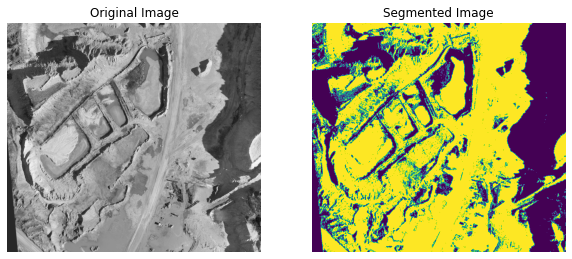

In [9]:
# Plot the original image and the segmented image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(label_array, cmap='viridis')
ax[1].set_title('Segmented Image')
ax[1].axis('off')
plt.show()

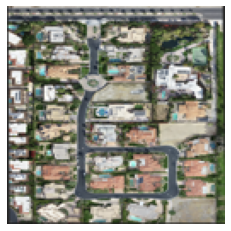

In [16]:
image = im2arr('demo2.png', RGB=True, resize=(128, 128))
plt.imshow(image)
plt.axis('off')
plt.show()

In [17]:
ang = img2ang(image)
print(ang.shape)
lm = [7 * np.pi / 4] * 3
shots = 1000
label_array = iqft_seg(ang, lm, shots) #lm tuning 

(128, 128, 3)


  0%|                                                   | 0/128 [00:00<?, ?it/s]

{0: 0.069, 1: 0.545, 2: 0.2, 3: 0.003, 4: 0.078, 5: 0.105}
{0: 0.022, 2: 0.022, 3: 0.243, 4: 0.088, 5: 0.019, 6: 0.218, 7: 0.388}
{0: 0.013, 2: 0.023, 3: 0.316, 4: 0.07, 5: 0.057, 6: 0.173, 7: 0.348}
{0: 0.062, 2: 0.009, 3: 0.162, 4: 0.104, 5: 0.009, 6: 0.259, 7: 0.395}
{0: 0.026, 2: 0.012, 3: 0.227, 4: 0.109, 5: 0.01, 6: 0.236, 7: 0.38}
{0: 0.04, 1: 0.002, 2: 0.022, 3: 0.209, 4: 0.09, 5: 0.023, 6: 0.231, 7: 0.383}


  1%|▎                                          | 1/128 [00:00<01:07,  1.88it/s]

{0: 0.012, 2: 0.024, 3: 0.289, 4: 0.075, 5: 0.033, 6: 0.211, 7: 0.356}


 16%|██████▌                                   | 20/128 [00:12<01:02,  1.73it/s]

{0: 0.052, 1: 0.449, 2: 0.25, 3: 0.009, 4: 0.1, 5: 0.139, 6: 0.001}
{1: 0.132, 2: 0.031, 3: 0.318, 5: 0.47, 6: 0.018, 7: 0.031}
{0: 0.001, 1: 0.323, 2: 0.034, 3: 0.237, 4: 0.001, 5: 0.397, 6: 0.006, 7: 0.001}
{0: 0.058, 1: 0.557, 2: 0.249, 3: 0.025, 4: 0.05, 5: 0.055, 7: 0.006}
{1: 0.164, 2: 0.001, 3: 0.474, 5: 0.352, 7: 0.009}
{0: 0.212, 1: 0.286, 2: 0.307, 4: 0.162, 5: 0.032, 6: 0.001}


 16%|██████▉                                   | 21/128 [00:12<00:59,  1.80it/s]

{0: 0.247, 1: 0.001, 2: 0.005, 3: 0.027, 4: 0.187, 5: 0.005, 6: 0.224, 7: 0.304}


 31%|█████████████▏                            | 40/128 [00:24<00:48,  1.83it/s]

{0: 0.542, 1: 0.188, 2: 0.138, 3: 0.007, 4: 0.105, 5: 0.001, 6: 0.01, 7: 0.009}
{1: 0.009, 2: 0.076, 3: 0.292, 4: 0.005, 5: 0.273, 6: 0.201, 7: 0.144}
{1: 0.056, 2: 0.157, 3: 0.468, 4: 0.007, 5: 0.208, 6: 0.079, 7: 0.025}
{0: 0.001, 1: 0.002, 2: 0.049, 3: 0.438, 4: 0.01, 5: 0.185, 6: 0.131, 7: 0.184}
{1: 0.634, 2: 0.004, 3: 0.103, 5: 0.255, 7: 0.004}
{0: 0.003, 1: 0.001, 2: 0.098, 3: 0.427, 4: 0.074, 5: 0.055, 6: 0.186, 7: 0.156}


 32%|█████████████▍                            | 41/128 [00:24<00:46,  1.88it/s]

{1: 0.034, 2: 0.004, 3: 0.486, 5: 0.338, 6: 0.01, 7: 0.128}


 47%|███████████████████▋                      | 60/128 [00:34<00:36,  1.87it/s]

{0: 0.46, 1: 0.216, 2: 0.154, 3: 0.012, 4: 0.127, 5: 0.003, 6: 0.021, 7: 0.007}
{0: 0.612, 1: 0.097, 2: 0.171, 3: 0.001, 4: 0.047, 5: 0.002, 6: 0.067, 7: 0.003}
{0: 0.001, 1: 0.473, 2: 0.04, 3: 0.251, 4: 0.003, 5: 0.225, 6: 0.002, 7: 0.005}
{0: 0.001, 1: 0.001, 2: 0.011, 3: 0.407, 4: 0.005, 5: 0.206, 6: 0.061, 7: 0.308}
{1: 0.196, 2: 0.002, 3: 0.47, 5: 0.324, 7: 0.008}
{0: 0.011, 1: 0.45, 2: 0.15, 3: 0.081, 4: 0.023, 5: 0.274, 6: 0.01, 7: 0.001}


 48%|████████████████████                      | 61/128 [00:35<00:35,  1.90it/s]

{0: 0.005, 2: 0.022, 3: 0.34, 4: 0.044, 5: 0.069, 6: 0.152, 7: 0.368}


 62%|██████████████████████████▎               | 80/128 [00:47<00:36,  1.31it/s]

{0: 0.583, 1: 0.123, 2: 0.119, 3: 0.011, 4: 0.133, 5: 0.001, 6: 0.019, 7: 0.011}
{1: 0.021, 2: 0.11, 3: 0.504, 4: 0.029, 5: 0.121, 6: 0.1, 7: 0.115}
{1: 0.064, 2: 0.008, 3: 0.492, 4: 0.001, 5: 0.376, 6: 0.004, 7: 0.055}
{0: 0.025, 2: 0.065, 3: 0.228, 4: 0.2, 5: 0.01, 6: 0.3, 7: 0.172}
{1: 0.193, 2: 0.004, 3: 0.441, 5: 0.346, 6: 0.004, 7: 0.012}
{1: 0.212, 2: 0.001, 3: 0.368, 5: 0.413, 7: 0.006}


 63%|██████████████████████████▌               | 81/128 [00:48<00:38,  1.22it/s]

{0: 0.011, 1: 0.3, 2: 0.224, 3: 0.059, 4: 0.053, 5: 0.292, 6: 0.061}


 78%|████████████████████████████████         | 100/128 [01:01<00:15,  1.85it/s]

{0: 0.651, 1: 0.109, 2: 0.095, 3: 0.009, 4: 0.11, 6: 0.015, 7: 0.011}
{0: 0.01, 1: 0.641, 2: 0.106, 3: 0.109, 4: 0.003, 5: 0.109, 7: 0.022}
{1: 0.202, 2: 0.002, 3: 0.503, 5: 0.291, 7: 0.002}
{1: 0.168, 2: 0.011, 3: 0.317, 4: 0.001, 5: 0.471, 6: 0.011, 7: 0.021}
{1: 0.1, 2: 0.139, 3: 0.383, 5: 0.263, 6: 0.09, 7: 0.025}
{0: 0.155, 1: 0.415, 2: 0.324, 3: 0.005, 4: 0.073, 5: 0.017, 6: 0.007, 7: 0.004}


 79%|████████████████████████████████▎        | 101/128 [01:01<00:14,  1.88it/s]

{0: 0.427, 1: 0.225, 2: 0.247, 3: 0.002, 4: 0.05, 5: 0.001, 6: 0.048}


 94%|██████████████████████████████████████▍  | 120/128 [01:12<00:05,  1.55it/s]

{0: 0.591, 1: 0.139, 2: 0.113, 3: 0.012, 4: 0.109, 6: 0.023, 7: 0.013}
{0: 0.407, 1: 0.007, 2: 0.007, 3: 0.01, 4: 0.211, 5: 0.012, 6: 0.164, 7: 0.182}
{0: 0.002, 1: 0.001, 2: 0.068, 3: 0.404, 4: 0.063, 5: 0.05, 6: 0.214, 7: 0.198}
{0: 0.019, 2: 0.034, 3: 0.287, 4: 0.095, 5: 0.024, 6: 0.252, 7: 0.289}
{0: 0.021, 2: 0.015, 3: 0.24, 4: 0.046, 5: 0.038, 6: 0.181, 7: 0.459}
{1: 0.091, 2: 0.003, 3: 0.494, 5: 0.368, 6: 0.006, 7: 0.038}


 95%|██████████████████████████████████████▊  | 121/128 [01:12<00:04,  1.61it/s]

{0: 0.001, 1: 0.007, 2: 0.036, 3: 0.536, 4: 0.005, 5: 0.182, 6: 0.064, 7: 0.169}


100%|█████████████████████████████████████████| 128/128 [01:16<00:00,  1.68it/s]


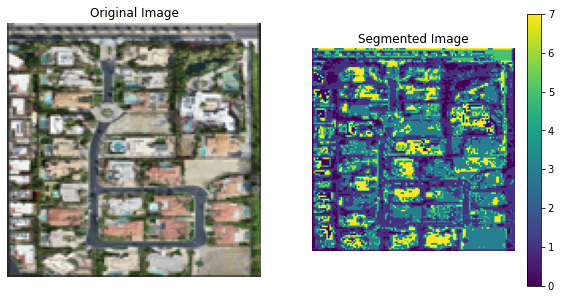

In [18]:
# Plot the original image and the segmented image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
hm = ax[1].imshow(label_array, cmap='viridis')
ax[1].set_title('Segmented Image')
ax[1].axis('off')
plt.colorbar(hm, ax=ax[1])
plt.show()

### Check against what linear algebra tells us ###

In [ ]:
qi.Operator(QFT(3).inverse()).to_matrix()

array([[ 3.53553391e-01+0.j        ,  3.53553391e-01+0.j        ,
         3.53553391e-01+0.j        ,  3.53553391e-01+0.j        ,
         3.53553391e-01+0.j        ,  3.53553391e-01+0.j        ,
         3.53553391e-01+0.j        ,  3.53553391e-01+0.j        ],
       [ 3.53553391e-01+0.j        ,  2.50000000e-01-0.25j      ,
         2.16489014e-17-0.35355339j, -2.50000000e-01-0.25j      ,
        -3.53553391e-01+0.j        , -2.50000000e-01+0.25j      ,
        -2.16489014e-17+0.35355339j,  2.50000000e-01+0.25j      ],
       [ 3.53553391e-01+0.j        ,  2.16489014e-17-0.35355339j,
        -3.53553391e-01+0.j        , -2.16489014e-17+0.35355339j,
         3.53553391e-01+0.j        ,  2.16489014e-17-0.35355339j,
        -3.53553391e-01+0.j        , -2.16489014e-17+0.35355339j],
       [ 3.53553391e-01+0.j        , -2.50000000e-01-0.25j      ,
        -2.16489014e-17+0.35355339j,  2.50000000e-01-0.25j      ,
        -3.53553391e-01+0.j        ,  2.50000000e-01+0.25j      ,
       

In [ ]:
w = np.exp(2j * np.pi / 8)
_wp = lambda x: w ** (x)
_wrgb = 1/np.sqrt(8) * np.array(
    [
        [1, 1, 1, 1, 1, 1, 1, 1], 
        [1, _wp(-1), _wp(-2), _wp(-3), _wp(-4), _wp(-5), _wp(-6), _wp(-7)],
        [1, _wp(-2), _wp(-4), _wp(-6), 1, _wp(-2), _wp(-4), _wp(-6)],
        [1, _wp(-3), _wp(-6), _wp(-1), _wp(-4), _wp(-7), _wp(-2), _wp(-5)],
        [1, _wp(-4), 1, _wp(-4), 1, _wp(-4), 1, _wp(-4)],
        [1, _wp(-5), _wp(-2), _wp(-7), _wp(-4), _wp(-1), _wp(-6), _wp(-3)],
        [1, _wp(-6), _wp(-4), _wp(-2), 1, _wp(-6), _wp(-4), _wp(-2)],
        [1, _wp(-7), _wp(-6), _wp(-5), _wp(-4), _wp(-3), _wp(-2), _wp(-1)],
    ]
)
np.isclose(_wrgb, qi.Operator(QFT(3).inverse()).to_matrix())

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

[ 0.35355339+0.j          0.33947146-0.0987883j  -0.23109792-0.26757009j
 -0.29665658-0.19234051j -0.14713013+0.32148519j -0.05144203+0.34979096j
  0.33947146-0.0987883j   0.29834743-0.18970717j]
0.9999999999999997


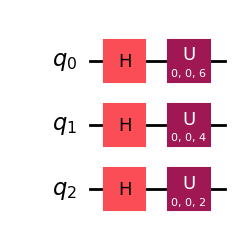

In [ ]:
alpha, beta, gamma = 2, 4, 6
angles = [alpha, beta, gamma]
angles.reverse()
qc = QuantumCircuit(3)
for k in range(3):
    qc.h(k)
    qc.u(0, 0, angles[k], k)
state = qi.Statevector.from_instruction(qc).data
print(state)
print(np.linalg.norm(state))
qc.draw('mpl')

In [ ]:
_exp = lambda x: np.exp(1j * x)
vec = np.array([1, _exp(gamma), _exp(beta), _exp(beta + gamma), _exp(alpha), _exp(alpha + gamma), _exp(alpha + beta), _exp(alpha + beta + gamma)])
print(vec / np.linalg.norm(vec))

np.isclose(state, vec / np.linalg.norm(vec))

[ 0.35355339+0.j          0.33947146-0.0987883j  -0.23109792-0.26757009j
 -0.29665658-0.19234051j -0.14713013+0.32148519j -0.05144203+0.34979096j
  0.33947146-0.0987883j   0.29834743-0.18970717j]


array([ True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
QC = QuantumCircuit(3)
QC.x(2)
state = Statevector.from_instruction(QC).data
qft = QFT(3)
# QC.append(qft, range(3))
op = qi.Operator(qft)
op_mat = op.to_matrix()

print(op_mat.dot(state))
# QC.measure_all()

# sampler = Sampler()
# res = sampler.run(QC, run_options={'shots':5000}).result()
# print(res)

[ 0.35355339+0.j -0.35355339+0.j  0.35355339+0.j -0.35355339+0.j
  0.35355339+0.j -0.35355339+0.j  0.35355339+0.j -0.35355339+0.j]
